<a href="https://colab.research.google.com/github/souaddev/Master-Thesis-Anomaly-Detection-in-Industrial-Control-Systems-Using-Dynamic-Time-Warping/blob/main/SWaT_DTW_Thesis_Souad_Asroubi_ipyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Thesis: Dynamic Time Warping Based Anomaly Detection For Industrial Control System**
 > **SWaT Dataset**


*   Souad Asroubi




#**1. Import libraries**

In [ ]:
!pip install fastdtw
from fastdtw import fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512617 sha256=7c2cb4c9847e74219afe82039adbb9c4e60dc55674a9cb39d83431b692e3787c
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
!pip install tensorflow==2.12.0
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

In [ ]:
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from keras.layers import TimeDistributed,Reshape
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, precision_score, make_scorer,r2_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score,classification_report,precision_recall_fscore_support,precision_recall_curve,mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#**Load Preprocessed Data**
>Loading the saved preprocessing dataset and separate the features and the target variable from the preprocessed dataset.

In [ ]:
SWaT_preprocessed = pd.read_csv('/content/drive/My Drive/swat/preprocessed_data.csv')

In [ ]:
X_df = SWaT_preprocessed.drop('Normal/Attack', axis=1)
y_df = SWaT_preprocessed['Normal/Attack']

In [ ]:
# Split the dataset into training and testing sets, reserving 30% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size=0.3, random_state=42, shuffle=False
)

In [ ]:
def evaluate_model_performance(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    auc = roc_auc_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

In [ ]:
# Plot training & validation loss values
def plot_training_validation_loss(history):
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc_curve(true_labels, predicted_probabilities,name):
    # Calculate ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
    auc = roc_auc_score(true_labels, predicted_probabilities)

    # Plotting the ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    roc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
    roc_data.to_csv('/content/drive/My Drive/souad_models/'+name+'_roc_curve.csv', index=False)

#**Baselines Implementation **

##AUTOENCODER

In [ ]:
# Isolate the normal observations from the training data to train the autoencoder
X_train_normal = X_train[y_train == 0]

In [ ]:
# Define the autoencoder model
# The model uses a single hidden layer with a dropout layer to prevent overfitting.

n_features= X_train_normal.shape[1]
dropout_rate = 0.5
def create_model(n_units=512, activation='sigmoid', optimizer='adam'):
    input_data = Input(shape=(n_features,))
    encoded = Dense(units=n_units, activation=activation)(input_data)
    encoded = Dropout(dropout_rate)(encoded)

    decoded = Dense(units=n_units // 4, activation=activation)(encoded)
    decoded = Dense(units=n_features, activation='linear')(decoded)

    autoencoder = Model(inputs=input_data, outputs=decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

    return autoencoder

---

### **Grid Search for Autoencoder Hyperparameter Tuning**

**Objective:** Fine-tune the autoencoder's hyperparameters to optimize anomaly detection performance using GridSearchCV.

- **Parameters Tested:** Neuron units (`256`, `512`), activation functions (`relu`, `sigmoid`), optimizers (`adam`, `rmsprop`), batch size (`256`), and epochs (`50`, `100`).
- **Validation:** Utilizes 3-fold cross-validation with the `f1_score` metric for robust evaluation across subsets.
- **Early Stopping:** Monitors validation loss, stops after 5 epochs without improvement to prevent overfitting.
- **Execution:** Runs exclusively on 'normal' data with 20% used for validation to hone in on minimizing reconstruction error.

---


In [ ]:
#GRID Search
model = KerasRegressor(build_fn=create_model, verbose=1)

param_grid = {
    'n_units': [256, 512],
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [256, 512],
    'epochs': [50,100]
}

#Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Custom score
f1_scorer = make_scorer(f1_score)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, scoring=f1_scorer, verbose=2)
grid_result = grid.fit(X_train_normal, X_train_normal, validation_split=0.2, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/50
1457/1457 [==============================] - 8s 5ms/step - loss: 0.0108 - accuracy: 0.1564 - val_loss: 0.0073 - val_accuracy: 0.2053
Epoch 2/50
1457/1457 [==============================] - 7s 5ms/step - loss: 0.0013 - accuracy: 0.1607 - val_loss: 0.0054 - val_accuracy: 0.4790
Epoch 3/50
1457/1457 [==============================] - 7s 5ms/step - loss: 8.2408e-04 - accuracy: 0.1327 - val_loss: 0.0046 - val_accuracy: 0.1308
Epoch 4/50
1457/1457 [==============================] - 7s 5ms/step - loss: 5.6695e-04 - accuracy: 0.1685 - val_loss: 0.0040 - val_accuracy: 0.0971
Epoch 5/50
1457/1457 [==============================] - 7s 5ms/step - loss: 4.1877e-04 - accuracy: 0.2144 - val_loss: 0.0036 - val_accuracy: 0.2285
Epoch 6/50
1457/1457 [==============================] - 7s 5ms/step - loss: 3.4226e-04 - accuracy: 0.2333 - val_loss: 0.0029 - val_accuracy: 0.0459
Epoch 7/50
1457/1457 [==============================] - 7s 

In [ ]:
joblib.dump(grid_result, '/content/drive/MyDrive/grid_search_results.pkl')

['/content/drive/MyDrive/grid_search_results.pkl']

In [ ]:
# Run the model with the best hyperparameters
model=create_model(n_units=512, activation='sigmoid', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history=model.fit(
    X_train_normal, X_train_normal,
    epochs=100,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

#make prediction on the the testing set
X_test_predictions = model.predict(X_test)

mae = np.mean(np.abs(X_test_predictions - X_test), axis=1)

Epoch 1/100
1002/1002 [==============================] - 9s 8ms/step - loss: 0.0229 - accuracy: 0.1232 - val_loss: 0.0039 - val_accuracy: 0.0119
Epoch 2/100
1002/1002 [==============================] - 7s 7ms/step - loss: 0.0040 - accuracy: 0.1366 - val_loss: 0.0029 - val_accuracy: 0.0027
Epoch 3/100
1002/1002 [==============================] - 8s 8ms/step - loss: 0.0023 - accuracy: 0.1011 - val_loss: 0.0027 - val_accuracy: 0.0044
Epoch 4/100
1002/1002 [==============================] - 7s 7ms/step - loss: 0.0017 - accuracy: 0.0742 - val_loss: 0.0026 - val_accuracy: 0.0031
Epoch 5/100
1002/1002 [==============================] - 7s 7ms/step - loss: 0.0014 - accuracy: 0.0543 - val_loss: 0.0024 - val_accuracy: 0.0025
Epoch 6/100
1002/1002 [==============================] - 7s 7ms/step - loss: 0.0011 - accuracy: 0.0624 - val_loss: 0.0024 - val_accuracy: 0.0892
Epoch 7/100
1002/1002 [==============================] - 7s 7ms/step - loss: 8.3909e-04 - accuracy: 0.0928 - val_loss: 0.0022 - va

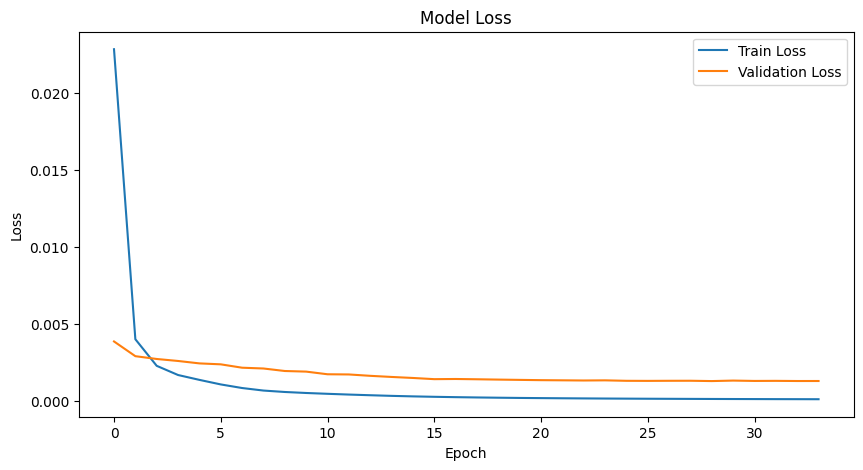

In [ ]:
plot_training_validation_loss(history)

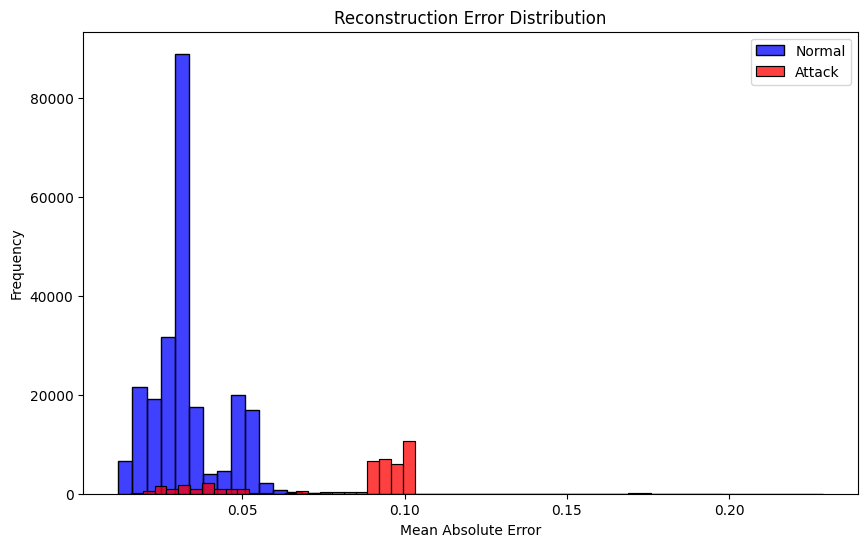

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(mae[y_test == 0], bins=50, color='blue', label='Normal')
sns.histplot(mae[y_test == 1], bins=50, color='red', label='Attack')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


---

### Optimal Threshold Determination for Anomaly Detection

**Purpose:** Find the threshold that yields the highest F1 score to effectively distinguish between normal operations and anomalies.

- **Threshold Range:** Compute 100 linearly spaced values between the minimum and maximum MAE.
- **Metrics Calculated:** Precision, recall, and F1 score for each threshold.
- **Optimization:** Track the best F1 score and corresponding threshold.
---

In [ ]:
#Find the best threshold
thresholds = np.linspace(min(mae), max(mae), num=100)
precision_list, recall_list, f1_list = [], [], []

best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    predicted_anomalies = (mae > threshold).astype(int)
    precision = precision_score(y_test, predicted_anomalies)
    recall = recall_score(y_test, predicted_anomalies)
    f1 = f1_score(y_test, predicted_anomalies)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best F1 Score: {best_f1}")
print(f"Threshold for Best F1 Score: {best_threshold}")

Best F1 Score: 0.8425718911417778
Threshold for Best F1 Score: 0.06439584572544543


In [ ]:
#Evaluation

# Generate predictions where MAE values above the threshold are considered anomalies.
y_pred = (mae > best_threshold).astype(int)
y_true = y_test

evaluate_model_performance(y_test, y_pred)

Accuracy: 0.9560
Confusion Matrix:
[[233631    600]
 [ 11652  32787]]
Precision: 0.9820
Recall: 0.7378
F1-score: 0.8426
AUC: 0.8676

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    234231
           1       0.98      0.74      0.84     44439

    accuracy                           0.96    278670
   macro avg       0.97      0.87      0.91    278670
weighted avg       0.96      0.96      0.95    278670



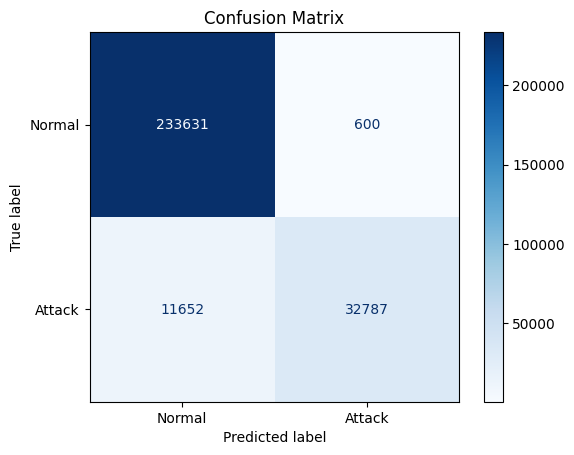

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred)


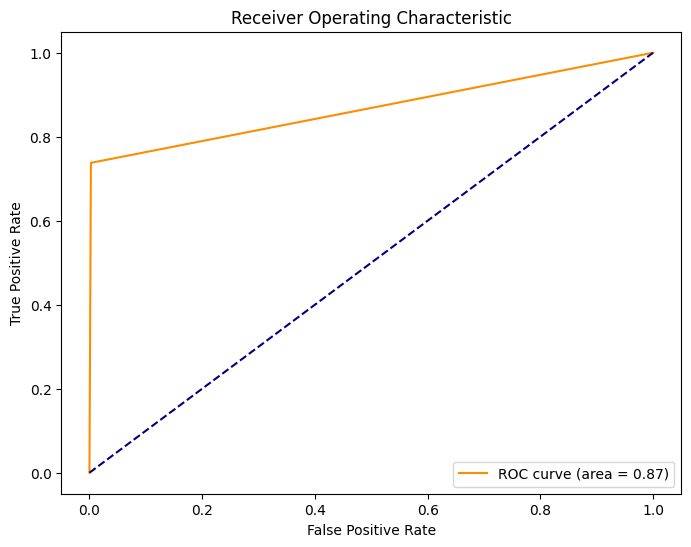

In [ ]:
plot_roc_curve(y_test, y_pred,'SWaT_Autoencoder_Baseline')

##LSTM

In [ ]:
# Split the dataset into training and testing sets, reserving 30% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size=0.3, random_state=42, shuffle=False
)

In [ ]:
# Reshaping: Convert the train and test dataframes into a suitable format for LSTM which requires input to be in the shape `[samples, time steps, features]`.
X_train1 = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test1 = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

**Model Definition:**
>- **LSTM Architecture:** Define a sequential model starting with an LSTM layer. LSTM is chosen for its ability to capture temporal dependencies and anomalies in time series data.
- **Units:** The LSTM layer has 50 units which is a balance between model complexity and computational efficiency.
- **Output Layer:** A dense layer with a sigmoid activation function predicts the binary outcome (normal/anomaly).
- **Compilation:** The model uses Adam optimizer and binary cross-entropy loss, suitable for binary classification tasks. It is also set to track accuracy during training.


In [ ]:
def create_lstm_model(units, dropout_rate=0.2, optimizer='RMSprop'):
    model = Sequential([
        LSTM(units=units, return_sequences=True, input_shape=(X_train1.shape[1], X_train1.shape[2])),
        Dropout(dropout_rate),
        LSTM(units=units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    if optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=0.0000001)
    else:
        opt = optimizer
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


### Hyperparameter Tuning with Grid Search

>**Setup:**
- **Model:** Utilizes a Keras model wrapped in a `KerasClassifier` for compatibility with scikit-learn's grid search functions.
- **Parameters to Tune:** The grid search tests various configurations of neural network parameters:
  - `units`: Number of neurons in the hidden layer (20, 50, 100) to understand the effect of network depth on performance.
  - `batch_size`: Batch sizes (16, 32, 64) to optimize the gradient descent updates.
  - `epochs`: Fixed at 10 to standardize the number of training cycles for each configuration.
  

>**Grid Search Execution:**
- **Scoring:** Uses the F1 score as the metric for evaluation, focusing on the balance between precision and recall, crucial for classification tasks with potentially imbalanced datasets.
- **Cross-validation:** Employs 3-fold cross-validation to ensure that the model's performance is not dependent on a particular split of the dataset.
- **Fit Model:** Executes the grid search to find the best model parameters based on the defined grid.


In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=1)

# Grid search
param_grid = {
    'units': [20, 50, 100],
    'batch_size': [16, 32, 64],
    'epochs': [10]
}

f1_scorer = make_scorer(f1_score)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, scoring=f1_scorer)
grid_result = grid.fit(X_train1, y_train)

Epoch 1/10
27093/27093 [==============================] - 89s 3ms/step - loss: 0.0691 - accuracy: 0.9831
Epoch 2/10
27093/27093 [==============================] - 81s 3ms/step - loss: 0.0530 - accuracy: 0.9863
Epoch 3/10
27093/27093 [==============================] - 80s 3ms/step - loss: 0.0475 - accuracy: 0.9879
Epoch 4/10
27093/27093 [==============================] - 81s 3ms/step - loss: 0.0438 - accuracy: 0.9888
Epoch 5/10
27093/27093 [==============================] - 77s 3ms/step - loss: 0.0415 - accuracy: 0.9895
Epoch 6/10
27093/27093 [==============================] - 79s 3ms/step - loss: 0.0394 - accuracy: 0.9900
Epoch 7/10
27093/27093 [==============================] - 92s 3ms/step - loss: 0.0378 - accuracy: 0.9906
Epoch 8/10
27093/27093 [==============================] - 112s 4ms/step - loss: 0.0363 - accuracy: 0.9908
Epoch 9/10
27093/27093 [==============================] - 77s 3ms/step - loss: 0.0351 - accuracy: 0.9911
Epoch 10/10
6774/6774 [==============================]

In [ ]:
print("Best parameters:", grid_result.best_params_)

Best parameters: {'units': 50, 'batch_size': 32, 'epochs': 10}


In [ ]:
lstm_model = create_lstm_model(units=50,dropout_rate=0.2)

history = lstm_model.fit(X_train1, y_train, epochs=10, batch_size=32,
    verbose=1,
    validation_split=0.2)

Epoch 1/10
16256/16256 [==============================] - 68s 4ms/step - loss: 0.0227 - accuracy: 0.9949 - val_loss: 0.2221 - val_accuracy: 0.9634
Epoch 2/10
16256/16256 [==============================] - 70s 4ms/step - loss: 0.0150 - accuracy: 0.9965 - val_loss: 0.2102 - val_accuracy: 0.9630
Epoch 3/10
16256/16256 [==============================] - 69s 4ms/step - loss: 0.0138 - accuracy: 0.9968 - val_loss: 0.2786 - val_accuracy: 0.9632
Epoch 4/10
16256/16256 [==============================] - 70s 4ms/step - loss: 0.0134 - accuracy: 0.9971 - val_loss: 0.2562 - val_accuracy: 0.9661
Epoch 5/10
16256/16256 [==============================] - 70s 4ms/step - loss: 0.0132 - accuracy: 0.9972 - val_loss: 0.2016 - val_accuracy: 0.9745
Epoch 6/10
16256/16256 [==============================] - 69s 4ms/step - loss: 0.0128 - accuracy: 0.9973 - val_loss: 0.2215 - val_accuracy: 0.9684
Epoch 7/10
16256/16256 [==============================] - 68s 4ms/step - loss: 0.0129 - accuracy: 0.9975 - val_loss: 0

In [ ]:
#Prediction on test dataset (outputs the probability scores for each sample in X_test_
predictions = lstm_model.predict(X_test1)

8709/8709 [==============================] - 21s 2ms/step


In [ ]:
#Find the best treshold
#The precision_recall_curve function computes precision-recall pairs for different probability thresholds on the provided target test set and the predictions
precisions, recalls, thresholds = precision_recall_curve(y_test, predictions)

# Calculate the F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores)

#Identify the threshold with the highest F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print("Best threshold: ", optimal_threshold)
print("Best F1-score: ", f1_scores[optimal_idx])

Best threshold:  0.0026060813
Best F1-score:  0.8521192537803246


In [ ]:
#Convert continuous predictions to binary format based on the optimal threshold
predictions_binary = (predictions >optimal_threshold).astype(int)

evaluate_model_performance(y_test, predictions_binary)

Accuracy: 0.8969
Confusion Matrix:
[[215695  18536]
 [ 10201  34238]]
Precision: 0.6488
Recall: 0.7704
F1-score: 0.7044
AUC: 0.8457

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94    234231
           1       0.65      0.77      0.70     44439

    accuracy                           0.90    278670
   macro avg       0.80      0.85      0.82    278670
weighted avg       0.91      0.90      0.90    278670



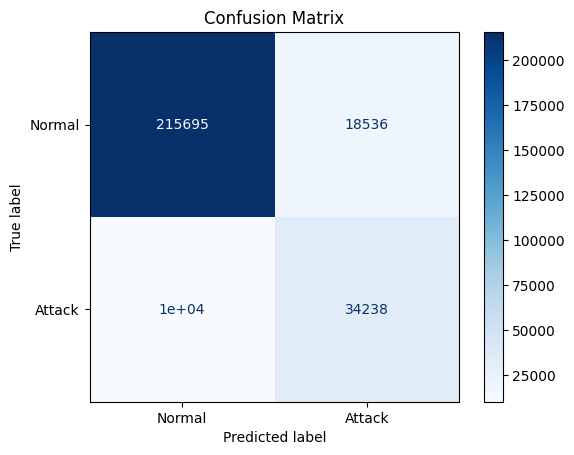

In [ ]:
plot_confusion_matrix(y_test, predictions_binary)

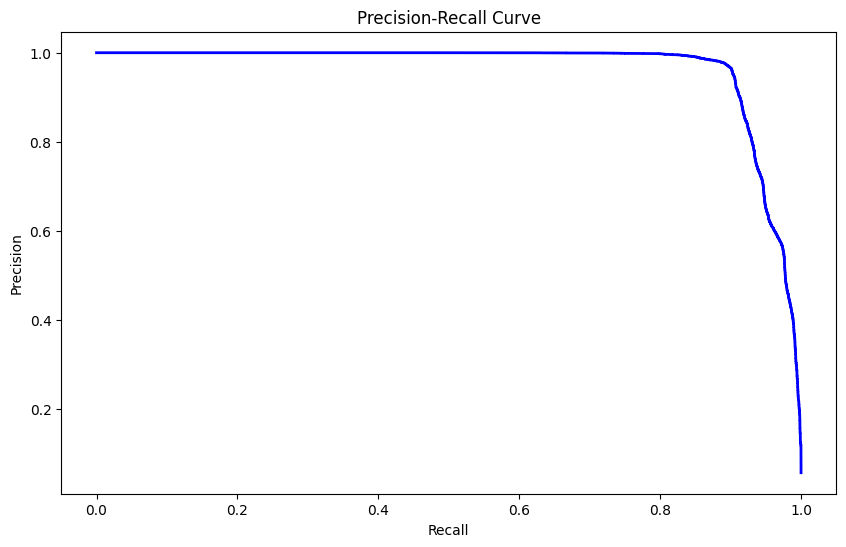

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

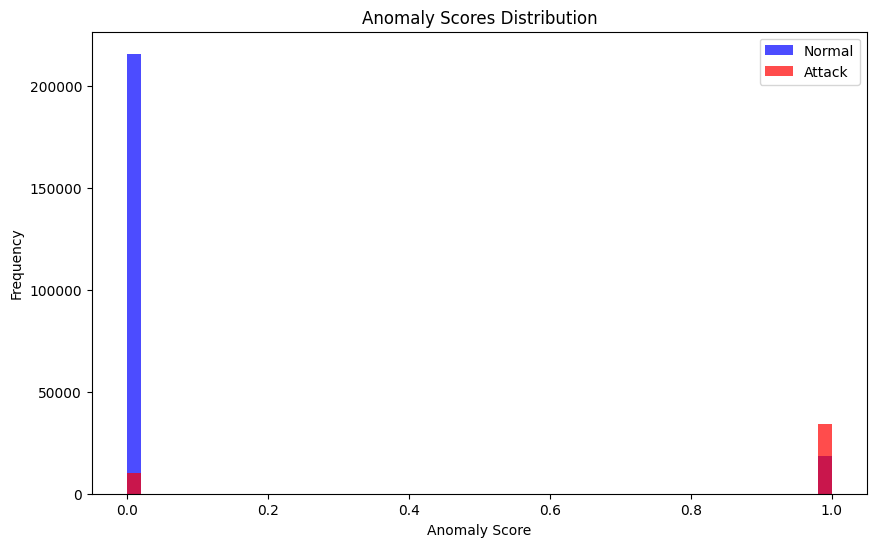

In [ ]:
anomaly_scores = predictions_binary

plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores[y_test == 0], bins=50, color='blue', alpha=0.7, label='Normal')
plt.hist(anomaly_scores[y_test == 1], bins=50, color='red', alpha=0.7, label='Attack')
plt.title('Anomaly Scores Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

##Isolation Forest

**Model Initialization**:
   - **Configuration**: Set `max_features` to 1.0, use all available processors (`n_jobs=-1`), fix `random_state` at 42 for reproducibility, and set verbose output to 0 for clean execution.
   

In [ ]:
model = IsolationForest(max_features=1.0, n_jobs=-1, random_state=42, verbose=0)

 **Contamination Estimation**:
   - Calculate the contamination parameter as the proportion of outliers (`y_df == 1`) to the total number of observations. This helps tailor the model to the specific outlier frequency of the dataset.
  

In [ ]:
# Calculate contamination as the proportion of outliers
outlier_count = np.sum(y_df == 1)
total_count = len(y_df)

contamination_estimate = outlier_count / total_count
print("Estimated contamination parameter: ", contamination_estimate)

Estimated contamination parameter:  0.05775445743235533


**Grid Search Setup**:
   >- **Parameter Grid**:
     - `n_estimators`: Number of trees (50, 100, 150).
     - `max_samples`: Proportion/number of samples to draw from X to train each base estimator (`auto`, 0.5, 0.75).
     - `contamination`: Proportion of outliers expected in data ([0.01, 0.05, 0.1]).
     - `bootstrap`: Whether samples are drawn with replacement (True, False).
   >- **Execution**: Conduct a 3-fold cross-validation to robustly assess the effectiveness of different configurations.


In [ ]:
#Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': ['auto', 0.5, 0.75],
    'contamination': [0.01, 0.05, 0.1],
    'bootstrap': [True, False]
}

f1_scorer = make_scorer(f1_score, greater_is_better=True)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=f1_scorer, verbose=2, n_jobs=1)
grid_search.fit(X_df)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=50; total time=   7.2s
[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=50; total time=   6.7s
[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=50; total time=   6.7s
[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=100; total time=  13.1s
[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=100; total time=  13.0s
[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=100; total time=  13.1s
[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=150; total time=  19.9s
[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=150; total time=  19.7s
[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=150; total time=  19.8s
[CV] END bootstrap=True, contamination=0.

GridSearchCV(cv=3, estimator=IsolationForest(n_jobs=-1, random_state=42),
             n_jobs=1,
             param_grid={'bootstrap': [True, False],
                         'contamination': [0.01, 0.05, 0.1],
                         'max_samples': ['auto', 0.5, 0.75],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(f1_score), verbose=2)

In [ ]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'bootstrap': True, 'contamination': 0.01, 'max_samples': 'auto', 'n_estimators': 50}


In [ ]:
#Run the model with the best hyperparameters
model = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(.01),
                             max_features=1.0, bootstrap=True, n_jobs=-1, random_state=42, verbose=0)

In [ ]:
# Fit the model to the training data
model.fit(X_train)

IsolationForest(bootstrap=True, contamination=0.01, n_estimators=50, n_jobs=-1,
                random_state=42)

In [ ]:
# Predict anomalies on the test data. The model outputs -1 for outliers and 1 for inliers
predictions = model.predict(X_test)

# Convert predictions from -1 to 0 for compatibility with binary classification evaluation.
binary_predictions = [1 if pred == -1 else 0 for pred in predictions]

true_labels = y_test
predicted_labels = binary_predictions

In [ ]:
# Evaluate the model's performance using accuracy, precision, recall, and F1 score
evaluate_model_performance(true_labels, predicted_labels)

Accuracy: 0.9433
Confusion Matrix:
[[231379   2852]
 [ 12962  31477]]
Precision: 0.9169
Recall: 0.7083
F1-score: 0.7992
AUC: 0.8481

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    234231
           1       0.92      0.71      0.80     44439

    accuracy                           0.94    278670
   macro avg       0.93      0.85      0.88    278670
weighted avg       0.94      0.94      0.94    278670



In [ ]:
# Anomaly Score Distribution
anomaly_scores = model.decision_function(X_test)

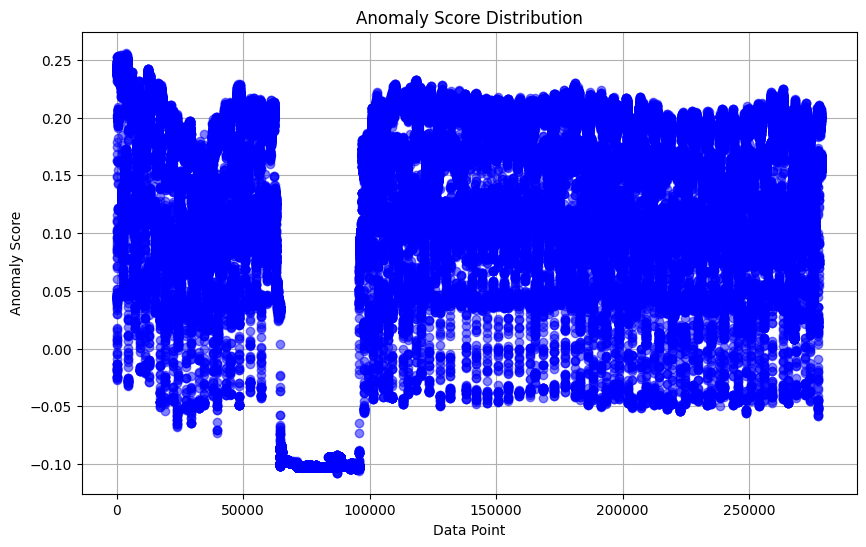

In [ ]:
# Plotting Residuals
plt.figure(figsize=(10, 6))
plt.plot(anomaly_scores, marker='o', linestyle='None', color='b', alpha=0.5)
plt.xlabel('Data Point')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Score Distribution')
plt.grid(True)
plt.show()

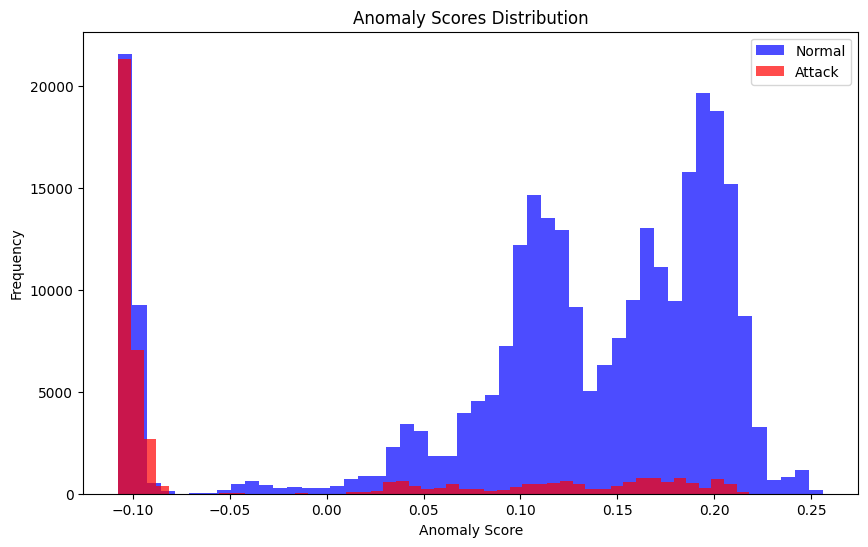

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores, bins=50, color='blue', alpha=0.7, label='Normal')
plt.hist(anomaly_scores[y_test == 1], bins=50, color='red', alpha=0.7, label='Attack')
plt.title('Anomaly Scores Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

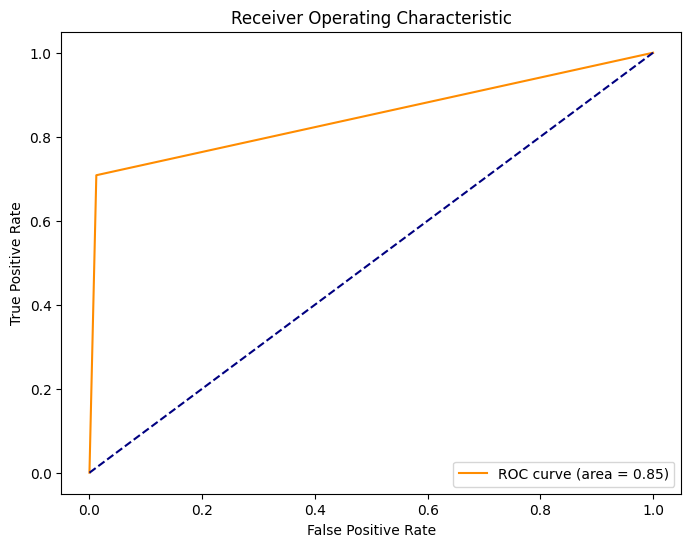

In [ ]:
plot_roc_curve(y_test, predicted_labels,'SWaT_IsolationF')

#**DTW Pairwise Approach Implementation**

## Calculate DTW Distances

In [ ]:
features_to_keep = [
    'FIT101', 'LIT101', 'AIT202', 'AIT203', 'DPIT301', 'FIT301', 'LIT301', 'AIT401',
    'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501',
    'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503'
]

new_df = X_df[features_to_keep]

In [ ]:
def create_sequences(data, window_size):
    sequences = []
    aligned_labels = []
    for start in range(len(data) - window_size + 1):
        end = start + window_size
        sequences.append(data[start:end])
    return np.array(sequences), np.array(aligned_labels)

### Function: Calculate DTW PairWise

**Purpose:** This function enhances the feature set by calculating the Dynamic Time Warping (DTW) distance between pairs of selected time series features within a specified window size (set to 10). It utilizes the FastDTW algorithm, which is an approximation of DTW but significantly faster, making it suitable for large datasets like the SWaT dataset.

**Process:**
>1. **Initialize DataFrame:** Create a new DataFrame `dtw_distances_df` to store the DTW distances, using the same index as the input DataFrame but starting from `window_size - 1` to accommodate the sequence creation.

>2. **Iterate Through Feature Pairs:**
   - For each pair of features, generate time series sequences using the `create_sequences` function.
   - Compute the FastDTW distance for each aligned pair of sequences, which measures the similarity by considering the optimal alignment between them.

>3. **Store Results:**
   - For each feature pair, store the computed DTW distances in the DataFrame under a new column.

**Return Value:** The function returns the DataFrame containing all the new DTW distance features, enriching the original dataset with time series similarity measures that can be crucial for detecting within time series datasets.

---

In [ ]:
def calculate_fastdtw_pairs(df, features, window_size):
    # Initialize a new DataFrame to store the DTW distances
    dtw_distances_df = pd.DataFrame(index=df.index[window_size - 1:])
    n = len(features)

    # Iterate through each feature pair
    for i in range(n):
        for j in range(i + 1, n):
            # Generate time series sequences for the feature pair
            series_i, _ = create_sequences(df[features[i]].values, window_size)
            series_j, _ = create_sequences(df[features[j]].values, window_size)

            # Compute FastDTW distances for each aligned pair of sequences
            # The parameter `dist=2` indicates the use of Euclidean distance as the distance metric
            dtw_distances = [fastdtw(series_i[k], series_j[k], dist= 2)[0] for k in range(len(series_i))]

            # Add the FastDTW distances as a new feature in the DataFrame
            feature_name = f'FastDTW_{features[i]}_{features[j]}'
            dtw_distances_df[feature_name] = dtw_distances

    return dtw_distances_df

In [ ]:
#Calculate DTW PairWise
dtw_distances_df= calculate_fastdtw_pairs(new_df, features_to_keep, 10)

In [ ]:
#Save the dtw_distances_df in csv format for future use
file_path = '/content/drive/My Drive/scaled_dtw_distances_finale.csv'
dtw_distances_df.to_csv(file_path)

In [ ]:
#Load the dtw_distances_df
dtw_distances_df = pd.read_csv('/content/drive/My Drive/scaled_dtw_distances_finale.csv')

In [ ]:
dtw_distances_df

Unnamed: 0  FastDTW_FIT101_LIT101  FastDTW_FIT101_AIT202  \
0                9               7.388695               1.652519   
1               10               7.446606               1.710653   
2               11               7.515558               1.780275   
3               12               7.592186               1.858019   
4               13               7.669644               1.937039   
...            ...                    ...                    ...   
928884      928893               4.996352               0.668791   
928885      928894               4.960853               0.638864   
928886      928895               4.910938               0.595012   
928887      928896               4.854695               0.545011   
928888      928897               4.791963               0.488743   

        FastDTW_FIT101_AIT203  FastDTW_FIT101_DPIT301  FastDTW_FIT101_FIT301  \
0                    8.245472                4.352955               0.423782   
1                    8.303606                4.410876               0.391148   
2                    8.373228                4.480284               0.360811   
3                    8.450972                4.558810               0.326317   
4                    8.529993                4.638613               0.284384   
...                       ...                     ...                    ...   
928884               8.922128                4.980678               0.270916   
928885               8.890641                4.947116               0.240978   
928886               8.845230                4.901124               0.208370   
928887               8.793670                4.851544               0.176983   
928888               8.735843                4.796479               0.155537   

        FastDTW_FIT101_LIT301  FastDTW_FIT101_AIT401  FastDTW_FIT101_AIT402  \
0                    7.162144               8.981434               7.415281   
1                    7.221291               9.039568               7.473416   
2                    7.292112               9.109190               7.543037   
3                    7.370869               9.186934               7.620782   
4                    7.450677               9.265955               7.699802   
...                       ...                    ...                    ...   
928884               1.621189               0.488093               9.263402   
928885               1.591288               0.519306               9.230860   
928886               1.547912               0.564445               9.185190   
928887               1.498161               0.615733               9.134168   
928888               1.441732               0.673287               9.076879   

        FastDTW_FIT101_FIT401  ...  FastDTW_FIT503_FIT504  \
0                    8.981434  ...               0.021794   
1                    9.039568  ...               0.021794   
2                    9.109190  ...               0.021794   
3                    9.186934  ...               0.021794   
4                    9.265955  ...               0.021794   
...                       ...  ...                    ...   
928884               0.254235  ...               0.077141   
928885               0.286182  ...               0.071281   
928886               0.331687  ...               0.065421   
928887               0.382902  ...               0.064007   
928888               0.439870  ...               0.063603   

        FastDTW_FIT503_PIT501  FastDTW_FIT503_PIT502  FastDTW_FIT503_PIT503  \
0                    0.022684               0.021794               0.037416   
1                    0.022684               0.021794               0.037416   
2                    0.022684               0.021794               0.037416   
3                    0.022684               0.021794               0.037416   
4                    0.022684               0.021794               0.037416   
...                       ...                    ...                    ..

In [ ]:
dtw_distances_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928889 entries, 0 to 928888
Columns: 232 entries, Unnamed: 0 to FastDTW_PIT502_PIT503
dtypes: float64(231), int64(1)
memory usage: 1.6 GB


In [ ]:
window_size=10
y_df_aligned = y_df[(window_size - 1):]

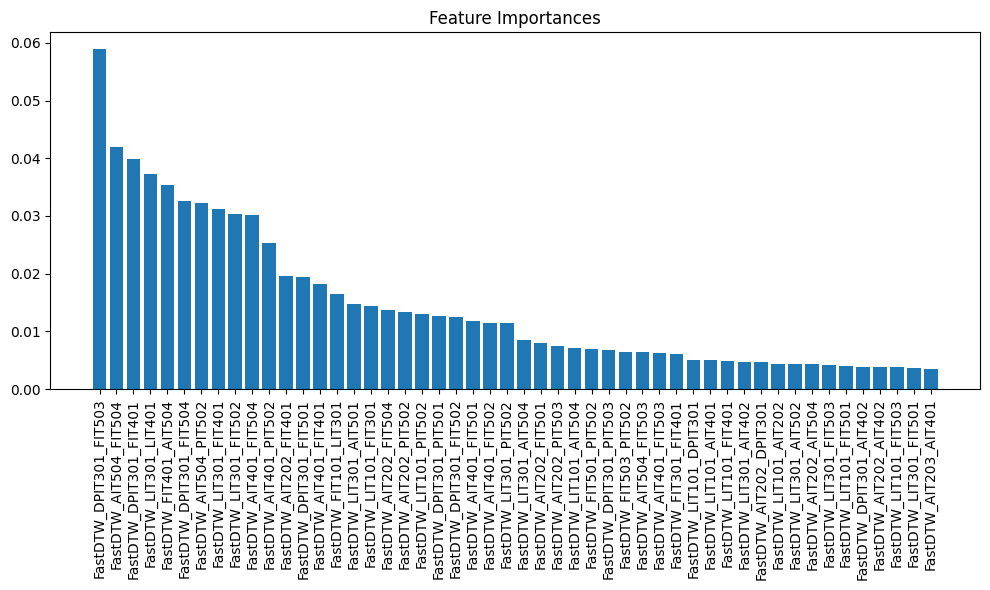

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(dtw_distances_df, y_df_aligned)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# top 50 feature
top_n_indices = indices[:50]
reduced_df = dtw_distances_df.iloc[:, top_n_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(len(top_n_indices)), importances[top_n_indices], align='center')
plt.xticks(range(len(top_n_indices)), dtw_distances_df.columns[top_n_indices], rotation=90)
plt.tight_layout()
plt.show()

file_path = '/content/drive/My Drive/reduced_dtw_distances.csv'
reduced_df.to_csv(file_path, index=False)

In [ ]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928889 entries, 9 to 928897
Data columns (total 50 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   FastDTW_DPIT301_FIT503  928889 non-null  float64
 1   FastDTW_AIT504_FIT504   928889 non-null  float64
 2   FastDTW_DPIT301_FIT401  928889 non-null  float64
 3   FastDTW_LIT301_LIT401   928889 non-null  float64
 4   FastDTW_FIT401_AIT504   928889 non-null  float64
 5   FastDTW_DPIT301_FIT504  928889 non-null  float64
 6   FastDTW_AIT504_PIT502   928889 non-null  float64
 7   FastDTW_LIT301_FIT401   928889 non-null  float64
 8   FastDTW_LIT301_FIT502   928889 non-null  float64
 9   FastDTW_AIT401_FIT504   928889 non-null  float64
 10  FastDTW_AIT401_PIT502   928889 non-null  float64
 11  FastDTW_AIT202_FIT401   928889 non-null  float64
 12  FastDTW_DPIT301_FIT501  928889 non-null  float64
 13  FastDTW_AIT401_FIT401   928889 non-null  float64
 14  FastDTW_FIT101_LIT30

In [ ]:
top_50_features = [
    'FastDTW_DPIT301_FIT503', 'FastDTW_AIT504_FIT504', 'FastDTW_DPIT301_FIT401',
    'FastDTW_LIT301_LIT401', 'FastDTW_FIT401_AIT504', 'FastDTW_DPIT301_FIT504',
    'FastDTW_AIT504_PIT502', 'FastDTW_LIT301_FIT401', 'FastDTW_LIT301_FIT502',
    'FastDTW_AIT401_FIT504', 'FastDTW_AIT401_PIT502', 'FastDTW_AIT202_FIT401',
    'FastDTW_DPIT301_FIT501', 'FastDTW_AIT401_FIT401', 'FastDTW_FIT101_LIT301',
    'FastDTW_LIT301_AIT501', 'FastDTW_LIT101_FIT301', 'FastDTW_AIT202_FIT504',
    'FastDTW_AIT202_PIT502', 'FastDTW_LIT101_PIT502', 'FastDTW_DPIT301_PIT501',
    'FastDTW_DPIT301_FIT502', 'FastDTW_AIT401_FIT501', 'FastDTW_AIT401_FIT502',
    'FastDTW_LIT301_PIT502', 'FastDTW_LIT301_AIT504', 'FastDTW_AIT202_FIT501',
    'FastDTW_AIT202_PIT503', 'FastDTW_LIT101_AIT504', 'FastDTW_FIT501_PIT502',
    'FastDTW_DPIT301_PIT503', 'FastDTW_FIT503_PIT502', 'FastDTW_AIT504_FIT503',
    'FastDTW_AIT401_FIT503', 'FastDTW_FIT301_FIT401', 'FastDTW_LIT101_DPIT301',
    'FastDTW_LIT101_AIT401', 'FastDTW_LIT101_FIT401', 'FastDTW_LIT301_AIT402',
    'FastDTW_AIT202_DPIT301', 'FastDTW_LIT101_AIT202', 'FastDTW_LIT301_AIT502',
    'FastDTW_AIT202_AIT504', 'FastDTW_LIT301_FIT503', 'FastDTW_LIT101_FIT501',
    'FastDTW_DPIT301_AIT402', 'FastDTW_AIT202_AIT402', 'FastDTW_LIT101_FIT503',
    'FastDTW_LIT301_FIT501', 'FastDTW_AIT203_AIT401'
]

reduced_df = dtw_distances_df[top_50_features]

In [ ]:
save_path = '/content/drive/My Drive/swat/top_features_df_finale.csv'
reduced_df.to_csv(save_path, index=False)

In [ ]:
reduced_df = pd.read_csv('/content/drive/My Drive/swat/top_features_df_finale.csv')

In [ ]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928889 entries, 0 to 928888
Data columns (total 50 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   FastDTW_DPIT301_FIT503  928889 non-null  float64
 1   FastDTW_AIT504_FIT504   928889 non-null  float64
 2   FastDTW_DPIT301_FIT401  928889 non-null  float64
 3   FastDTW_LIT301_LIT401   928889 non-null  float64
 4   FastDTW_FIT401_AIT504   928889 non-null  float64
 5   FastDTW_DPIT301_FIT504  928889 non-null  float64
 6   FastDTW_AIT504_PIT502   928889 non-null  float64
 7   FastDTW_LIT301_FIT401   928889 non-null  float64
 8   FastDTW_LIT301_FIT502   928889 non-null  float64
 9   FastDTW_AIT401_FIT504   928889 non-null  float64
 10  FastDTW_AIT401_PIT502   928889 non-null  float64
 11  FastDTW_AIT202_FIT401   928889 non-null  float64
 12  FastDTW_DPIT301_FIT501  928889 non-null  float64
 13  FastDTW_AIT401_FIT401   928889 non-null  float64
 14  FastDTW_FIT101_LIT30

In [ ]:
reduced_df.head(3)

FastDTW_DPIT301_FIT503  FastDTW_AIT504_FIT504  FastDTW_DPIT301_FIT401  \
0                4.606686               0.122835                4.628479   
1                4.606899               0.122835                4.628693   
2                4.607112               0.122835                4.628906   

   FastDTW_LIT301_LIT401  FastDTW_FIT401_AIT504  FastDTW_DPIT301_FIT504  \
0               0.584894               0.122835                4.628479   
1               0.583706               0.122835                4.628693   
2               0.581625               0.122835                4.628906   

   FastDTW_AIT504_PIT502  FastDTW_LIT301_FIT401  FastDTW_LIT301_FIT502  \
0               0.122835               1.819290               1.808945   
1               0.122835               1.818278               1.807933   
2               0.122835               1.817078               1.806733   

   FastDTW_AIT401_FIT504  ...  FastDTW_LIT101_AIT202  FastDTW_LIT301_AIT502  \
0                    0.0  ...               5.736176               1.464631   
1                    0.0  ...               5.735953               1.465464   
2                    0.0  ...               5.735284               1.466664   

   FastDTW_AIT202_AIT504  FastDTW_LIT301_FIT503  FastDTW_LIT101_FIT501  \
0               7.206081               1.797496               1.583260   
1               7.206081               1.796484               1.583483   
2               7.206081               1.795284               1.584153   

   FastDTW_DPIT301_AIT402  FastDTW_AIT202_AIT402  FastDTW_LIT101_FIT503  \
0                3.062327               5.762763               1.570946   
1                3.062540               5.762763               1.571169   
2                3.062754               5.762763               1.571838   

   FastDTW_LIT301_FIT501  FastDTW_AIT203_AIT401  
0               1.809811               0.735962  
1               1.808798               0.735962  
2               1.807598               0.735962  

[3 rows x 50 columns]

In [ ]:
missing_values = reduced_df.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 Unnamed: 0                0
FastDTW_FIT101_LIT101     0
FastDTW_FIT101_AIT202     0
FastDTW_FIT101_AIT203     0
FastDTW_FIT101_DPIT301    0
                         ..
FastDTW_FIT504_PIT502     0
FastDTW_FIT504_PIT503     0
FastDTW_PIT501_PIT502     0
FastDTW_PIT501_PIT503     0
FastDTW_PIT502_PIT503     0
Length: 232, dtype: int64


In [ ]:
merged_df = pd.concat([reduced_df, y_df_aligned], axis=1)

In [ ]:
merged_df.head(2)

FastDTW_DPIT301_FIT503  FastDTW_AIT504_FIT504  FastDTW_DPIT301_FIT401  \
0                4.606686               0.122835                4.628479   
1                4.606899               0.122835                4.628693   

   FastDTW_LIT301_LIT401  FastDTW_FIT401_AIT504  FastDTW_DPIT301_FIT504  \
0               0.584894               0.122835                4.628479   
1               0.583706               0.122835                4.628693   

   FastDTW_AIT504_PIT502  FastDTW_LIT301_FIT401  FastDTW_LIT301_FIT502  \
0               0.122835               1.819290               1.808945   
1               0.122835               1.818278               1.807933   

   FastDTW_AIT401_FIT504  ...  FastDTW_LIT301_AIT502  FastDTW_AIT202_AIT504  \
0                    0.0  ...               1.464631               7.206081   
1                    0.0  ...               1.465464               7.206081   

   FastDTW_LIT301_FIT503  FastDTW_LIT101_FIT501  FastDTW_DPIT301_AIT402  \
0               1.797496               1.583260                3.062327   
1               1.796484               1.583483                3.062540   

   FastDTW_AIT202_AIT402  FastDTW_LIT101_FIT503  FastDTW_LIT301_FIT501  \
0               5.762763               1.570946               1.809811   
1               5.762763               1.571169               1.808798   

   FastDTW_AIT203_AIT401  Normal/Attack  
0               0.735962            NaN  
1               0.735962            NaN  

[2 rows x 51 columns]

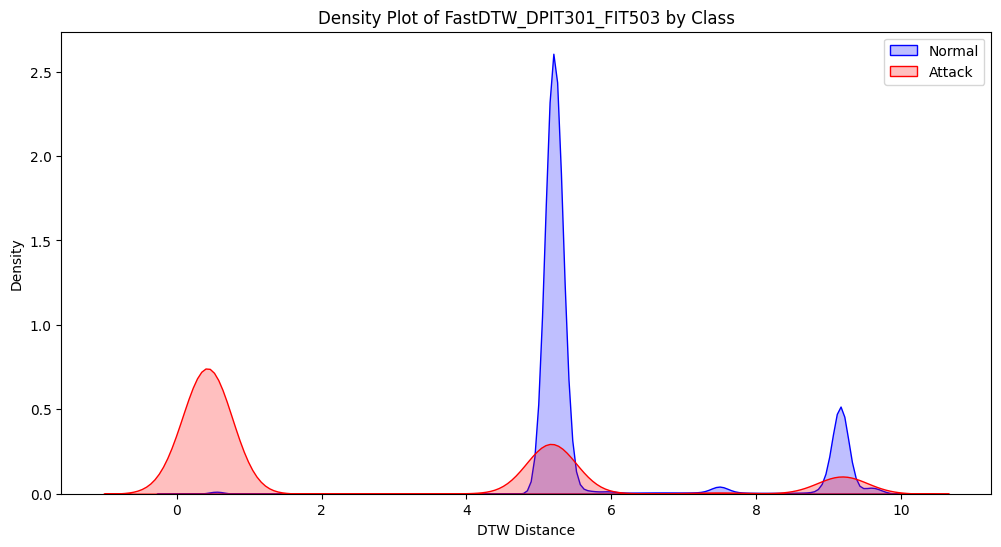

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.kdeplot(data=merged_df[merged_df['Normal/Attack'] == 0]['FastDTW_DPIT301_FIT503'], label='Normal', shade=True, color='blue')
sns.kdeplot(data=merged_df[merged_df['Normal/Attack'] == 1]['FastDTW_DPIT301_FIT503'], label='Attack', shade=True, color='red')
plt.xlabel('DTW Distance')
plt.ylabel('Density')
plt.title('Density Plot of FastDTW_DPIT301_FIT503 by Class')
plt.legend()
plt.show()


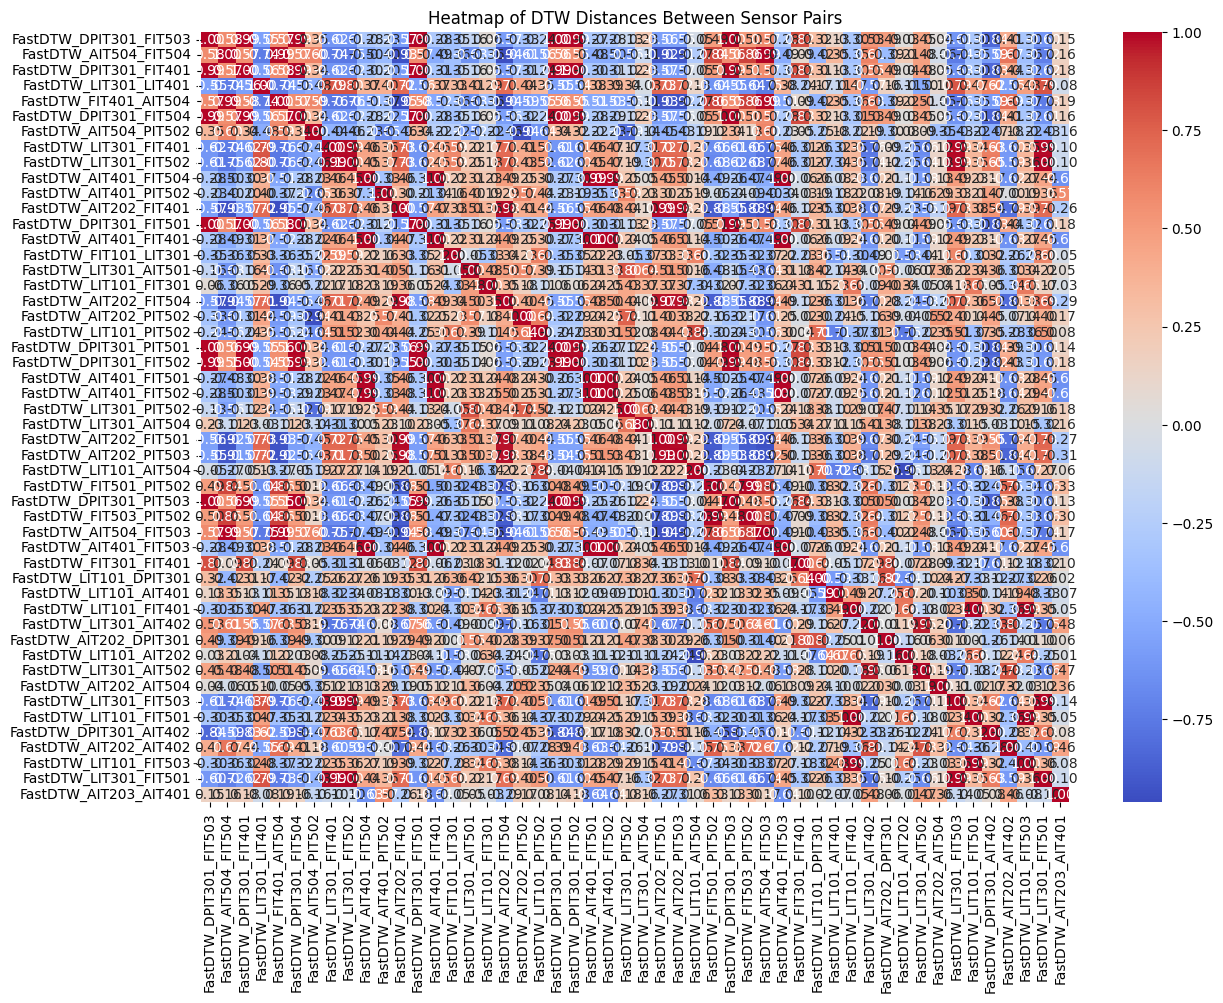

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(reduced_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of DTW Distances Between Sensor Pairs')
plt.show()

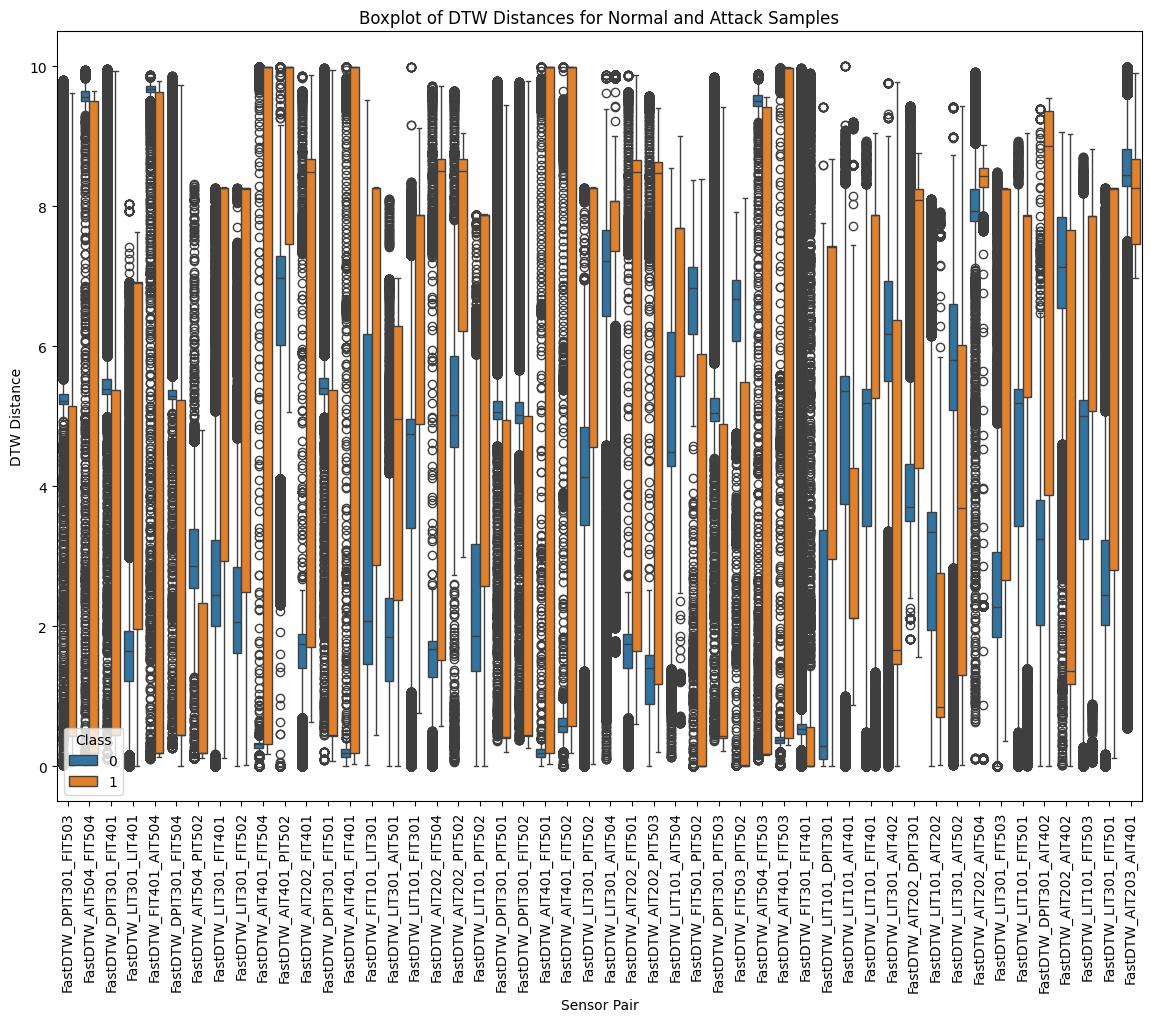

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adding a 'Class' column to dtw_distances_df for Normal (0) and Attack (1) labels
reduced_df1=reduced_df
reduced_df1['Class'] = y_df_aligned.values

# Melting the DataFrame for easier plotting with seaborn
melted_df = pd.melt(reduced_df1, id_vars=['Class'], var_name='Sensor Pair', value_name='DTW Distance')

plt.figure(figsize=(14, 10))
sns.boxplot(x='Sensor Pair', y='DTW Distance', hue='Class', data=melted_df)
plt.xticks(rotation=90)
plt.title('Boxplot of DTW Distances for Normal and Attack Samples')
plt.show()

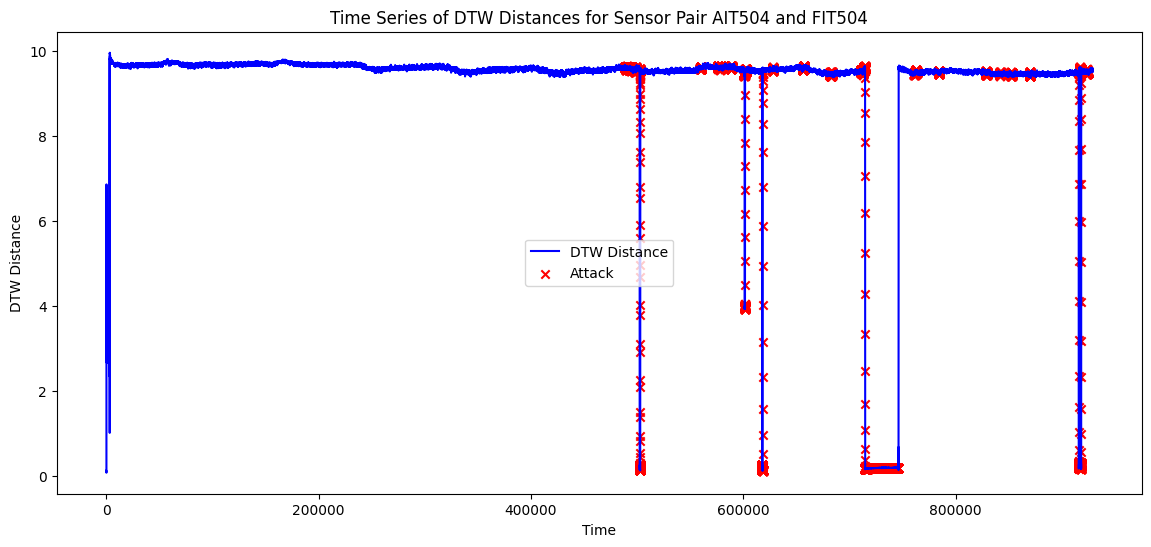

In [ ]:
# Plotting DTW distances for a selected sensor pair over time
attack_indices = y_df_aligned[y_df_aligned == 1].index

plt.figure(figsize=(14, 6))
plt.plot(reduced_df.index, reduced_df['FastDTW_AIT504_FIT504'], label='DTW Distance', color='blue')
plt.scatter(attack_indices, reduced_df.loc[attack_indices, 'FastDTW_AIT504_FIT504'], color='red', label='Attack', marker='x')
plt.xlabel('Time')
plt.ylabel('DTW Distance')
plt.title('Time Series of DTW Distances for Sensor Pair AIT504 and FIT504')
plt.legend()
plt.show()

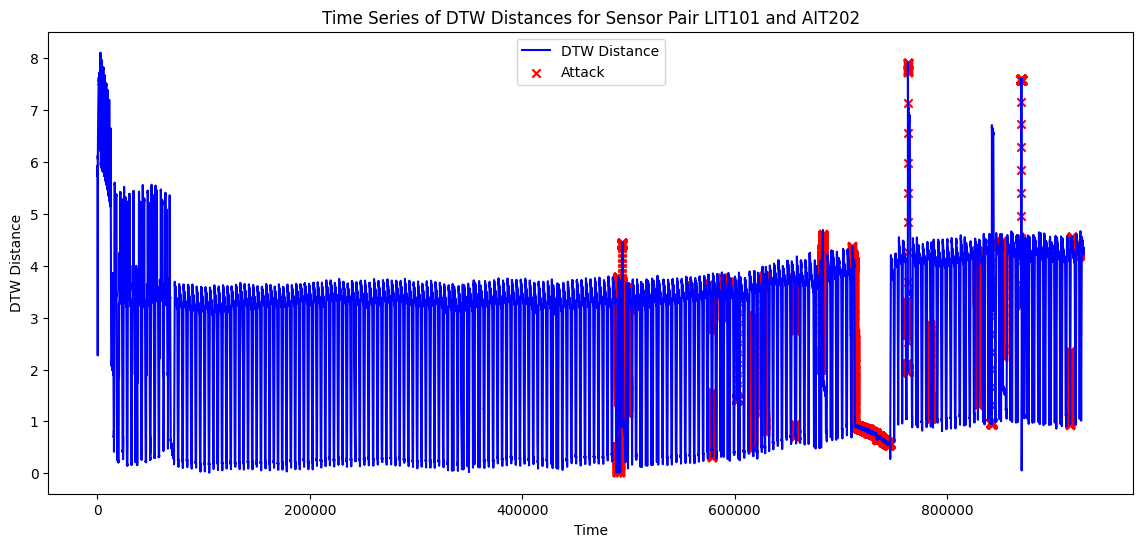

In [ ]:
attack_indices = y_df_aligned[y_df_aligned == 1].index

plt.figure(figsize=(14, 6))
plt.plot(reduced_df.index, reduced_df['FastDTW_LIT101_AIT202'], label='DTW Distance', color='blue')
plt.scatter(attack_indices, reduced_df.loc[attack_indices, 'FastDTW_LIT101_AIT202'], color='red', label='Attack', marker='x')
plt.xlabel('Time')
plt.ylabel('DTW Distance')
plt.title('Time Series of DTW Distances for Sensor Pair LIT101 and AIT202')
plt.legend()
plt.show()

##AutoEncoder + *DTW*

In [ ]:
window_size=10
y_df_aligned = y_df[(window_size - 1):]
X_train, X_test, y_train, y_test = train_test_split(
    reduced_df, y_df_aligned, test_size=0.3, random_state=42, shuffle=False
)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train_normal = X_train[y_train == 0]
n_features= X_train_normal.shape[1]

In [ ]:
def create_model_autoencoder(n_features, n_units=512, activation='sigmoid', dropout_rate=0.5, optimizer='adam'):

    input_data = Input(shape=(n_features,))
    encoded = Dense(units=n_units, activation=activation)(input_data)
    encoded = Dropout(dropout_rate)(encoded)

    decoded = Dense(units=n_units // 4, activation=activation)(encoded)
    decoded = Dense(units=n_features, activation='linear')(decoded)

    autoencoder = Model(inputs=input_data, outputs=decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

    return autoencoder

In [ ]:
#Grid search
model = KerasRegressor(build_fn=create_model_autoencoder(n_features), verbose=1)

param_grid = {
    'n_units': [256, 512],
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [256, 512],
    'epochs': [50,100]
    }

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
f1_scorer = make_scorer(f1_score)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, scoring=f1_scorer, verbose=2)
grid_result = grid.fit(X_train_normal, X_train_normal, validation_split=0.2, callbacks=[early_stopping])

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/50
1336/1336 [==============================] - 7s 5ms/step - loss: 0.7860 - accuracy: 0.4790 - val_loss: 0.0906 - val_accuracy: 0.8307
Epoch 2/50
1336/1336 [==============================] - 6s 4ms/step - loss: 0.1403 - accuracy: 0.7392 - val_loss: 0.0537 - val_accuracy: 0.8673
Epoch 3/50
1336/1336 [==============================] - 5s 4ms/step - loss: 0.0497 - accuracy: 0.8325 - val_loss: 0.0453 - val_accuracy: 0.8327
Epoch 4/50
1336/1336 [==============================] - 6s 4ms/step - loss: 0.0364 - accuracy: 0.8531 - val_loss: 0.0563 - val_accuracy: 0.8274
Epoch 5/50
1336/1336 [==============================] - 6s 4ms/step - loss: 0.0281 - accuracy: 0.8601 - val_loss: 0.0732 - val_accuracy: 0.8275
Epoch 6/50
1336/1336 [==============================] - 6s 4ms/step - loss: 0.0208 - accuracy: 0.8827 - val_loss: 0.0657 - val_accuracy: 0.8278
Epoch 7/50
1336/1336 [==============================] - 6s 4ms/step - loss:

In [ ]:
print("Best param: %s" % ( grid_result.best_params_))

Best param: {'activation': 'relu', 'batch_size': 256, 'epochs': 50, 'n_units': 256, 'optimizer': 'adam'}


In [ ]:
#Model with best param
model=create_model_autoencoder(n_features, n_units=256, activation='relu')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Training the model
history = model.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
2004/2004 [==============================] - 11s 5ms/step - loss: 0.6863 - accuracy: 0.3923 - val_loss: 0.0804 - val_accuracy: 0.8190
Epoch 2/50
2004/2004 [==============================] - 10s 5ms/step - loss: 0.1020 - accuracy: 0.5754 - val_loss: 0.0431 - val_accuracy: 0.9017
Epoch 3/50
2004/2004 [==============================] - 12s 6ms/step - loss: 0.0523 - accuracy: 0.6285 - val_loss: 0.0368 - val_accuracy: 0.9329
Epoch 4/50
2004/2004 [==============================] - 10s 5ms/step - loss: 0.0372 - accuracy: 0.6863 - val_loss: 0.0347 - val_accuracy: 0.8805
Epoch 5/50
2004/2004 [==============================] - 10s 5ms/step - loss: 0.0315 - accuracy: 0.7305 - val_loss: 0.0356 - val_accuracy: 0.9524
Epoch 6/50
2004/2004 [==============================] - 10s 5ms/step - loss: 0.0276 - accuracy: 0.7590 - val_loss: 0.0370 - val_accuracy: 0.8693
Epoch 7/50
2004/2004 [==============================] - 10s 5ms/step - loss: 0.0248 - accuracy: 0.7917 - val_loss: 0.0359 - val_ac

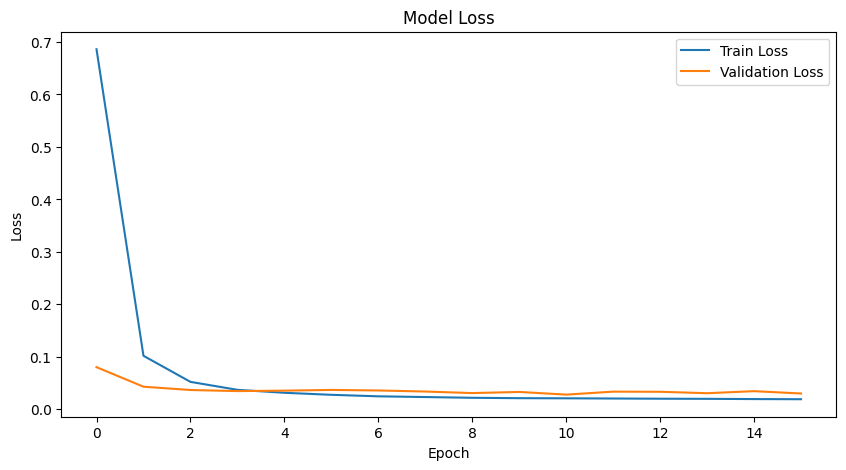

In [ ]:
plot_training_validation_loss(history)

In [ ]:
X_test_predictions = model.predict(X_test)

mae = np.mean(np.abs(X_test_predictions - X_test), axis=1)

8709/8709 [==============================] - 13s 1ms/step


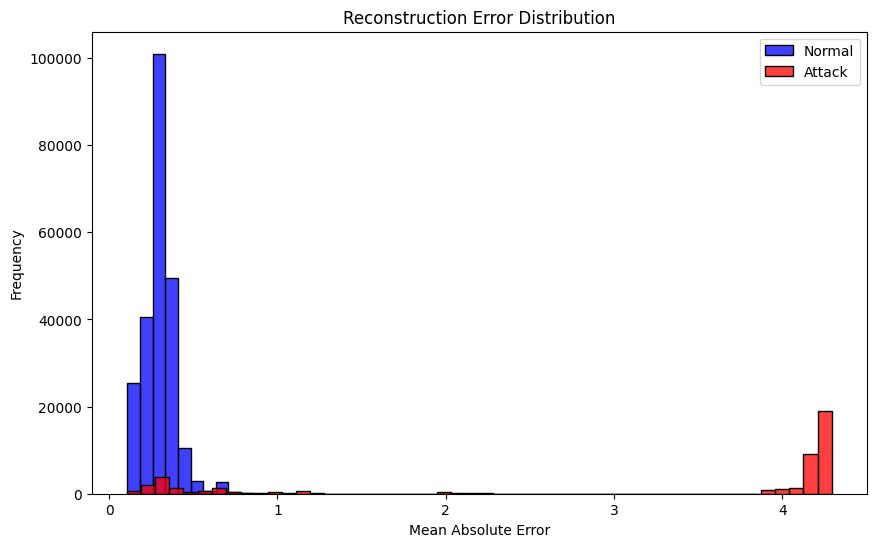

In [ ]:
mae = pd.Series(mae, index=y_test.index)

plt.figure(figsize=(10, 6))
sns.histplot(mae[y_test == 0], bins=50, color='blue', label='Normal')
sns.histplot(mae[y_test == 1], bins=50, color='red', label='Attack')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
#Find the best threshold
thresholds = np.linspace(min(mae), max(mae), num=100)
precision_list, recall_list, f1_list = [], [], []

best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    predicted_anomalies = (mae > threshold).astype(int)
    precision = precision_score(y_test, predicted_anomalies)
    recall = recall_score(y_test, predicted_anomalies)
    f1 = f1_score(y_test, predicted_anomalies)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best F1 Score: {best_f1}")
print(f"Threshold for Best F1 Score: {best_threshold}")

Best F1 Score: 0.8603366115786272
Threshold for Best F1 Score: 0.7412332630636524


In [ ]:
y_pred = (mae > best_threshold).astype(int)

evaluate_model_performance(y_test,y_pred)

Accuracy: 0.9605
Confusion Matrix:
[[233705    523]
 [ 10497  33942]]
Precision: 0.9848
Recall: 0.7638
F1-score: 0.8603
AUC: 0.8808

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    234228
           1       0.98      0.76      0.86     44439

    accuracy                           0.96    278667
   macro avg       0.97      0.88      0.92    278667
weighted avg       0.96      0.96      0.96    278667



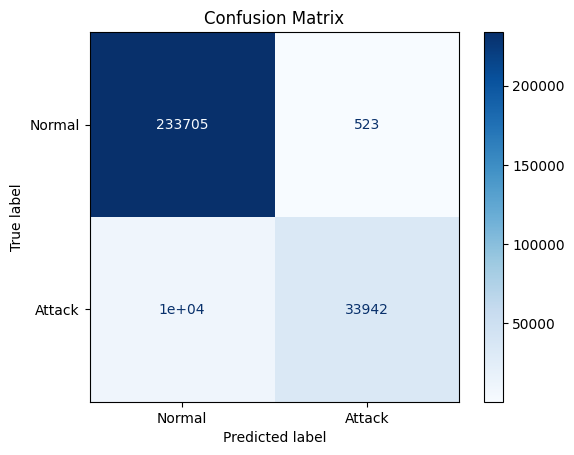

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred)


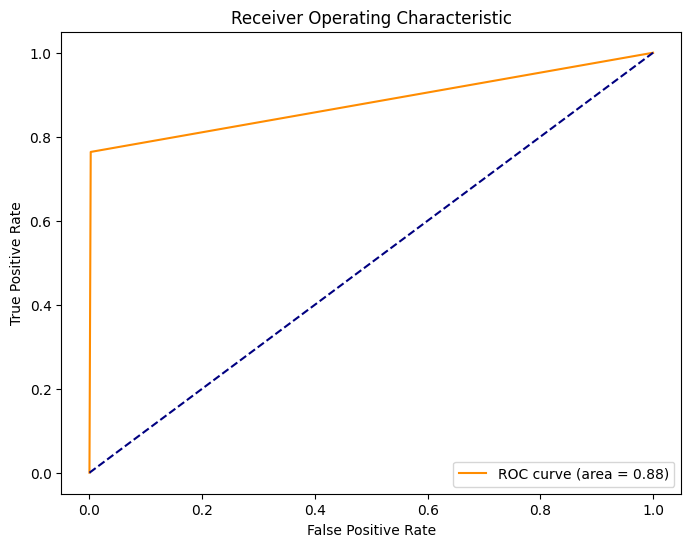

In [ ]:
plot_roc_curve(y_test, y_pred,'SWaT_Autoencoder_DTW_P')

##LSTM + DTW

In [ ]:
train_data_dtw_2, df_test_dtw_2, target_train_dtw_2, target_test_dtw_2 = train_test_split(
    reduced_df, y_df_aligned, test_size=0.3, random_state=42
)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both the training and test data
train_data_dtw_2_scaled = scaler.fit_transform(train_data_dtw_2)
df_test_dtw_2_scaled = scaler.transform(df_test_dtw_2)


#reshape the data
train_data_dtw_2 = train_data_dtw_2.values.reshape((train_data_dtw_2.shape[0], 1, train_data_dtw_2.shape[1]))
df_test_dtw_2 = df_test_dtw_2.values.reshape((df_test_dtw_2.shape[0], 1, df_test_dtw_2.shape[1]))

In [ ]:
def create_lstm_model(units, dropout_rate=0.2, optimizer='RMSprop'):
    model = Sequential([
        LSTM(units=units, return_sequences=True, input_shape=(train_data_dtw_2.shape[1], train_data_dtw_2.shape[2])),
        Dropout(dropout_rate),
        LSTM(units=units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    if optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=0.00001)
    else:
        opt = optimizer
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#Grid Search
model = KerasClassifier(build_fn=create_model_lstm, verbose=1)
param_grid = {
    'units': [50, 100, 150],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'epochs': [10],
}

f1_scorer = make_scorer(f1_score)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=f1_scorer, verbose=1)
grid_result = grid.fit(train_data_dtw_2, target_train_dtw_2, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Epoch 1/10
10837/10837 [==============================] - 38s 3ms/step - loss: 0.0525 - accuracy: 0.9868 - val_loss: 0.0350 - val_accuracy: 0.9901
Epoch 2/10
10837/10837 [==============================] - 37s 3ms/step - loss: 0.0281 - accuracy: 0.9916 - val_loss: 0.0244 - val_accuracy: 0.9927
Epoch 3/10
10837/10837 [==============================] - 39s 4ms/step - loss: 0.0200 - accuracy: 0.9940 - val_loss: 0.0182 - val_accuracy: 0.9944
Epoch 4/10
10837/10837 [==============================] - 38s 3ms/step - loss: 0.0163 - accuracy: 0.9949 - val_loss: 0.0151 - val_accuracy: 0.9948
Epoch 5/10
10837/10837 [==============================] - 39s 4ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0137 - val_accuracy: 0.9950
Epoch 6/10
10837/10837 [==============================] - 38s 4ms/step - loss: 0.0127 - accuracy: 0.9958 - val_loss: 0.0130 - val_accuracy: 0.9959
Epoch 7/10
10837/10837 [==============================] -

In [ ]:
#LSTM with best params
lstm_model=create_model_lstm(units=150, learning_rate=0.001)


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = lstm_model.fit(
    train_data_dtw_2, target_train_dtw_2,
    epochs=10,
    batch_size=32,
    verbose=1,
    validation_split=0.2,callbacks=[early_stopping]
)

Epoch 1/10
16256/16256 [==============================] - 132s 8ms/step - loss: 0.0687 - accuracy: 0.9842 - val_loss: 0.0615 - val_accuracy: 0.9856
Epoch 2/10
16256/16256 [==============================] - 132s 8ms/step - loss: 0.0592 - accuracy: 0.9866 - val_loss: 0.0565 - val_accuracy: 0.9868
Epoch 3/10
16256/16256 [==============================] - 140s 9ms/step - loss: 0.0545 - accuracy: 0.9873 - val_loss: 0.0546 - val_accuracy: 0.9863
Epoch 4/10
16256/16256 [==============================] - 140s 9ms/step - loss: 0.0512 - accuracy: 0.9879 - val_loss: 0.0555 - val_accuracy: 0.9865
Epoch 5/10
16256/16256 [==============================] - 144s 9ms/step - loss: 0.0475 - accuracy: 0.9886 - val_loss: 0.0452 - val_accuracy: 0.9891
Epoch 6/10
16256/16256 [==============================] - 152s 9ms/step - loss: 0.0458 - accuracy: 0.9889 - val_loss: 0.0432 - val_accuracy: 0.9886
Epoch 7/10
16256/16256 [==============================] - 141s 9ms/step - loss: 0.0438 - accuracy: 0.9893 - val_

In [ ]:
y_pred_prob = lstm_model.predict(df_test_dtw_2)

8709/8709 [==============================] - 19s 2ms/step


In [ ]:
precision, recall, thresholds = precision_recall_curve(target_test_dtw_2, y_pred_prob)

f1_scores = 2 * precision * recall / (precision + recall)

optimal_idx = np.argmax(f1_scores[np.isfinite(f1_scores)])
optimal_threshold = thresholds[optimal_idx]

print("The optimal threshold is :",optimal_threshold)

The optimal threshold is : 0.8673375


In [ ]:
y_pred = (y_pred_prob > optimal_threshold).astype(int)
evaluate_model_performance(target_test_dtw_2, y_pred)

Accuracy: 0.9926
Confusion Matrix:
[[262347    350]
 [  1721  14249]]
Precision: 0.9760
Recall: 0.8922
F1-score: 0.9323
AUC: 0.9455

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    262697
           1       0.98      0.89      0.93     15970

    accuracy                           0.99    278667
   macro avg       0.98      0.95      0.96    278667
weighted avg       0.99      0.99      0.99    278667



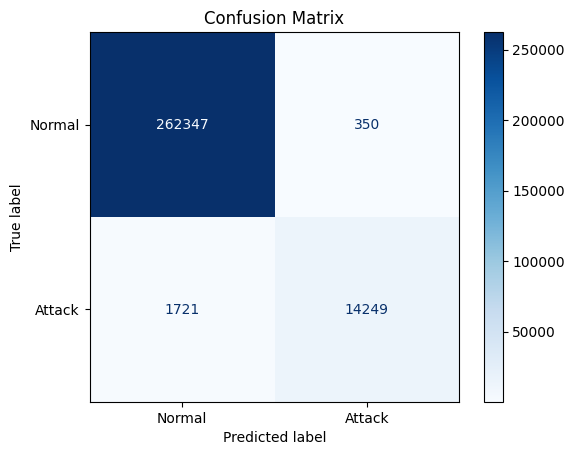

In [ ]:
plot_confusion_matrix(target_test_dtw_2, y_pred)

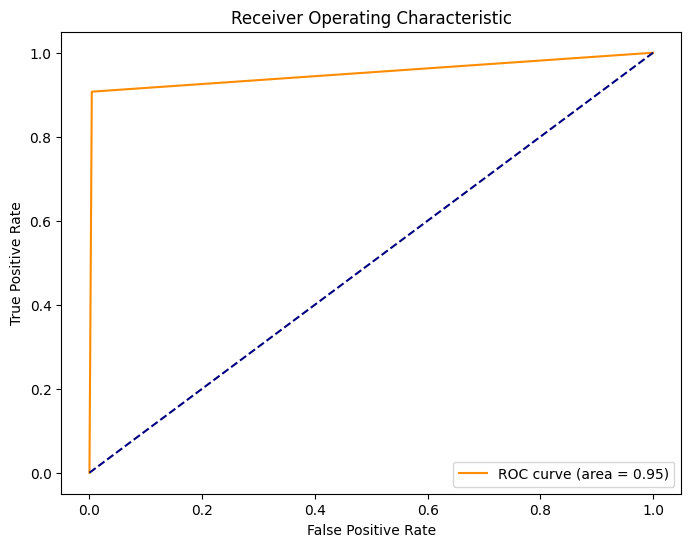

In [ ]:
plot_roc_curve(target_test_dtw_2, y_pred,'SWaT_LSTM_DTW_P')

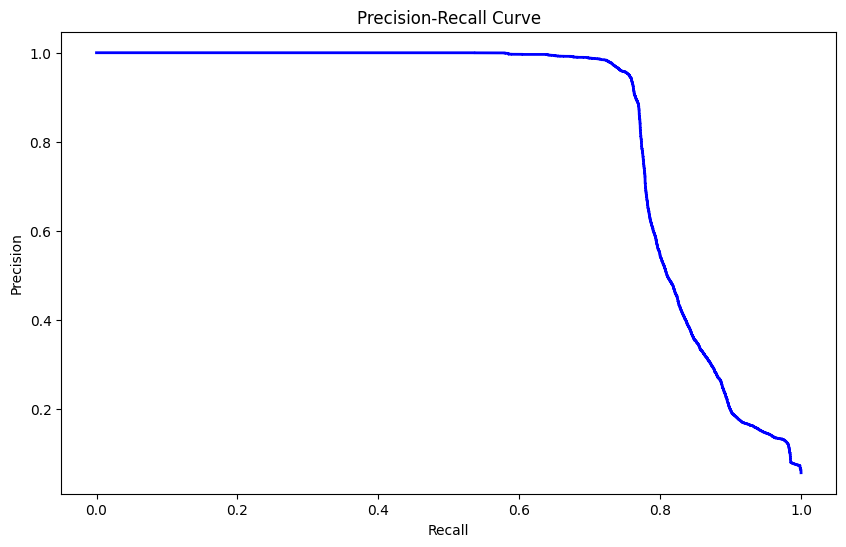

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

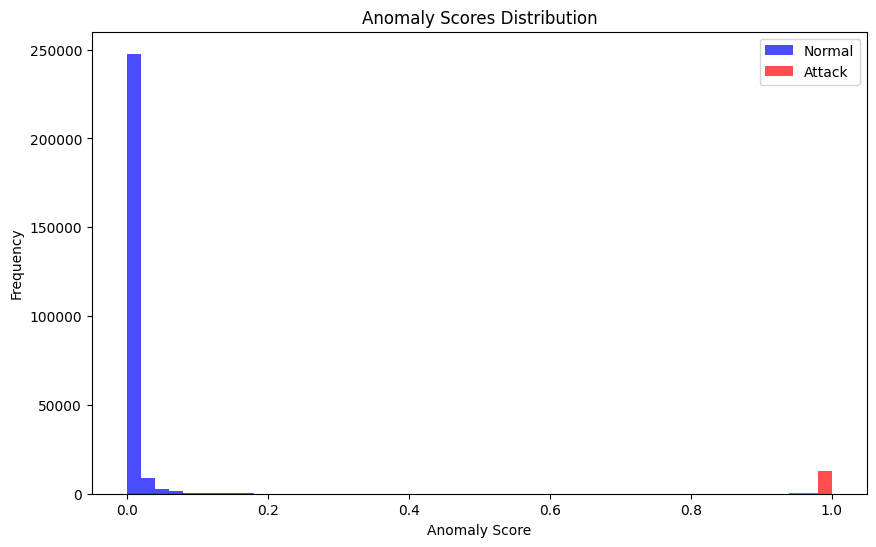

In [ ]:
anomaly_scores = y_pred_prob

plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores[target_test_dtw_2 == 0], bins=50, color='blue', alpha=0.7, label='Normal')
plt.hist(anomaly_scores[target_test_dtw_2 == 1], bins=50, color='red', alpha=0.7, label='Attack')
plt.title('Anomaly Scores Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

##Isolation Forest + DTW

In [ ]:
# Calculate contamination as the proportion of outliers
outlier_count = np.sum(y_train == 1)
total_count = len(y_train)

contamination_estimate = outlier_count / total_count
print("Estimated contamination parameter: ", contamination_estimate)

Estimated contamination parameter:  0.01416285514793409


In [ ]:
#Grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': ['auto', 0.5, 0.75],
    'contamination': [0.01, 0.05, 0.1],
    'bootstrap': [True, False]
}

f1_scorer = make_scorer(f1_score, greater_is_better=True)

model = IsolationForest(max_features=1.0, n_jobs=-1, random_state=42, verbose=1)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=f1_scorer, verbose=2, n_jobs=1)
grid_search.fit(X_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=50; total time=  13.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=50; total time=  14.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=50; total time=  13.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=100; total time=  26.5s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=100; total time=  25.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=100; total time=  27.5s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=150; total time=  36.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=150; total time=  38.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=auto, n_estimators=150; total time=  36.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.0s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.1s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.5, n_estimators=50; total time=  23.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.1s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.2s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.5, n_estimators=50; total time=  21.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.1s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.2s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.5, n_estimators=50; total time=  25.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.2s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.5, n_estimators=100; total time=  43.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.5, n_estimators=100; total time=  40.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.5, n_estimators=100; total time=  39.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.8s remaining:    8.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.9s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.5, n_estimators=150; total time=  58.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.0s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.5, n_estimators=150; total time=  59.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.8s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.0s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.5, n_estimators=150; total time=  57.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.75, n_estimators=50; total time=  21.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.75, n_estimators=50; total time=  21.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.75, n_estimators=50; total time=  20.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.4s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.75, n_estimators=100; total time=  40.8s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.5s remaining:    7.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.75, n_estimators=100; total time=  41.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    6.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.75, n_estimators=100; total time=  40.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.5s remaining:   10.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.8s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.6s remaining:   10.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.7s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.5s remaining:   10.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.7s finished


[CV] END bootstrap=True, contamination=0.01, max_samples=0.75, n_estimators=150; total time= 1.1min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=auto, n_estimators=50; total time=  13.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=auto, n_estimators=50; total time=  13.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=auto, n_estimators=50; total time=  13.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=auto, n_estimators=100; total time=  24.8s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=auto, n_estimators=100; total time=  24.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=auto, n_estimators=100; total time=  24.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=auto, n_estimators=150; total time=  36.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=auto, n_estimators=150; total time=  35.8s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=auto, n_estimators=150; total time=  36.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.0s remaining:    2.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.1s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.5, n_estimators=50; total time=  20.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.0s remaining:    2.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.1s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.5, n_estimators=50; total time=  21.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.5, n_estimators=50; total time=  22.8s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.5, n_estimators=100; total time=  40.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.0s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.5, n_estimators=100; total time=  40.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.1s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.5, n_estimators=100; total time=  39.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.0s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.5, n_estimators=150; total time=  58.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.9s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.1s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.5, n_estimators=150; total time=  59.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.9s remaining:    8.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.1s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.5, n_estimators=150; total time=  57.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.75, n_estimators=50; total time=  20.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.75, n_estimators=50; total time=  21.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.3s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.75, n_estimators=50; total time=  20.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    6.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.75, n_estimators=100; total time=  39.8s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.4s remaining:    7.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.75, n_estimators=100; total time=  40.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    7.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.6s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.75, n_estimators=100; total time=  39.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.5s remaining:   10.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.6s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.75, n_estimators=150; total time=  58.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.6s remaining:   10.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.9s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.5s remaining:   10.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.7s finished


[CV] END bootstrap=True, contamination=0.05, max_samples=0.75, n_estimators=150; total time=  57.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=auto, n_estimators=50; total time=  13.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=auto, n_estimators=50; total time=  13.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=auto, n_estimators=50; total time=  13.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=auto, n_estimators=100; total time=  24.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=auto, n_estimators=100; total time=  24.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=auto, n_estimators=100; total time=  24.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=auto, n_estimators=150; total time=  35.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=auto, n_estimators=150; total time=  36.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=auto, n_estimators=150; total time=  35.8s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.9s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.0s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.5, n_estimators=50; total time=  20.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.1s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.1s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.5, n_estimators=50; total time=  21.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.9s remaining:    2.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.1s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.5, n_estimators=50; total time=  20.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.0s remaining:    6.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.1s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.5, n_estimators=100; total time=  40.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.5, n_estimators=100; total time=  40.5s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.0s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.5, n_estimators=100; total time=  39.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.9s remaining:    8.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.2s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.5, n_estimators=150; total time=  59.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.9s remaining:    8.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.1s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.5, n_estimators=150; total time=  59.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.8s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.9s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.5, n_estimators=150; total time=  58.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.3s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.75, n_estimators=50; total time=  21.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.75, n_estimators=50; total time=  21.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.75, n_estimators=50; total time=  20.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.75, n_estimators=100; total time=  40.5s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.4s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.6s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.75, n_estimators=100; total time=  40.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.4s remaining:    7.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.6s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.75, n_estimators=100; total time=  39.8s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.5s remaining:   10.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.6s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.75, n_estimators=150; total time=  59.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.7s remaining:   11.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.8s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.3s remaining:    9.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.5s finished


[CV] END bootstrap=True, contamination=0.1, max_samples=0.75, n_estimators=150; total time=  58.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=auto, n_estimators=50; total time=  13.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=auto, n_estimators=50; total time=  13.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=auto, n_estimators=50; total time=  13.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=auto, n_estimators=100; total time=  24.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=auto, n_estimators=100; total time=  24.5s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=auto, n_estimators=100; total time=  24.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=auto, n_estimators=150; total time=  36.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=auto, n_estimators=150; total time=  36.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=auto, n_estimators=150; total time=  35.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.0s remaining:    5.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.1s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.5, n_estimators=50; total time=  21.5s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.5, n_estimators=50; total time=  22.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.5, n_estimators=50; total time=  21.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.0s remaining:   11.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.2s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.5, n_estimators=100; total time=  41.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.1s remaining:   12.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.3s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.5, n_estimators=100; total time=  42.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.0s remaining:   12.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.2s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.5, n_estimators=100; total time=  40.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.2s remaining:   18.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.4s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.5, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.1s remaining:   18.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.3s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.5, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.1s remaining:   18.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.4s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.5, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.75, n_estimators=50; total time=  21.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.75, n_estimators=50; total time=  21.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    6.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.75, n_estimators=50; total time=  21.5s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.3s remaining:   12.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.6s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.75, n_estimators=100; total time=  42.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.4s remaining:   13.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.7s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.75, n_estimators=100; total time=  41.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.4s remaining:   13.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.5s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.75, n_estimators=100; total time=  41.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.8s remaining:   20.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.1s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.9s remaining:   20.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.1s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.7s remaining:   20.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.9s finished


[CV] END bootstrap=False, contamination=0.01, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=auto, n_estimators=50; total time=  12.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=auto, n_estimators=50; total time=  12.8s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=auto, n_estimators=50; total time=  13.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=auto, n_estimators=100; total time=  24.5s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=auto, n_estimators=100; total time=  24.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=auto, n_estimators=100; total time=  24.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=auto, n_estimators=150; total time=  35.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=auto, n_estimators=150; total time=  35.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=auto, n_estimators=150; total time=  35.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.0s remaining:    6.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.1s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.5, n_estimators=50; total time=  21.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.5, n_estimators=50; total time=  22.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.1s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.5, n_estimators=50; total time=  21.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.0s remaining:   11.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.1s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.5, n_estimators=100; total time=  41.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.2s remaining:   12.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.4s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.5, n_estimators=100; total time=  42.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.9s remaining:   11.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.2s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.5, n_estimators=100; total time=  40.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.1s remaining:   18.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.3s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.5, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.0s remaining:   18.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.3s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.5, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.1s remaining:   18.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.2s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.5, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.75, n_estimators=50; total time=  21.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.75, n_estimators=50; total time=  21.8s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.4s remaining:    7.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.6s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.75, n_estimators=50; total time=  21.7s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.5s remaining:   13.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.8s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.75, n_estimators=100; total time=  42.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.5s remaining:   13.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.8s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.75, n_estimators=100; total time=  42.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.4s remaining:   13.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.7s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.75, n_estimators=100; total time=  41.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.7s remaining:   20.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.0s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.9s remaining:   20.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.0s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.7s remaining:   20.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.0s finished


[CV] END bootstrap=False, contamination=0.05, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=auto, n_estimators=50; total time=  13.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=auto, n_estimators=50; total time=  13.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=auto, n_estimators=50; total time=  13.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=auto, n_estimators=100; total time=  24.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=auto, n_estimators=100; total time=  24.5s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=auto, n_estimators=100; total time=  24.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=auto, n_estimators=150; total time=  36.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=auto, n_estimators=150; total time=  36.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=auto, n_estimators=150; total time=  36.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.5, n_estimators=50; total time=  21.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.0s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.5, n_estimators=50; total time=  22.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.0s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.5, n_estimators=50; total time=  21.3s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.2s remaining:   12.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.4s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.5, n_estimators=100; total time=  43.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.3s remaining:   13.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.5s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.5, n_estimators=100; total time=  43.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.2s remaining:   12.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.4s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.5, n_estimators=100; total time=  40.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.0s remaining:   17.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.4s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.5, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.1s remaining:   18.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.2s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.5, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.0s remaining:   18.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.2s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.5, n_estimators=150; total time=  60.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    6.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.75, n_estimators=50; total time=  21.9s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.75, n_estimators=50; total time=  21.8s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.75, n_estimators=50; total time=  21.6s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.4s remaining:   13.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.6s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.75, n_estimators=100; total time=  42.2s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.5s remaining:   13.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.8s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.75, n_estimators=100; total time=  42.1s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.5s remaining:   13.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.8s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.75, n_estimators=100; total time=  41.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.5s remaining:   19.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.8s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.7s remaining:   20.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.9s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.5s remaining:   19.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.8s finished


[CV] END bootstrap=False, contamination=0.1, max_samples=0.75, n_estimators=150; total time= 1.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


GridSearchCV(cv=3,
             estimator=IsolationForest(n_jobs=-1, random_state=42, verbose=1),
             n_jobs=1,
             param_grid={'bootstrap': [True, False],
                         'contamination': [0.01, 0.05, 0.1],
                         'max_samples': ['auto', 0.5, 0.75],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(f1_score), verbose=2)

In [ ]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'bootstrap': True, 'contamination': 0.01, 'max_samples': 'auto', 'n_estimators': 50}
Best score: nan


In [ ]:
model = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(.01),
                             max_features=1.0, bootstrap=True, n_jobs=-1, random_state=42, verbose=0)

In [ ]:
model.fit(X_train)

IsolationForest(bootstrap=True, contamination=0.01, n_estimators=50, n_jobs=-1,
                random_state=42)

In [ ]:
predictions = model.predict(X_test)

binary_predictions = [1 if pred == -1 else 0 for pred in predictions]

true_labels = y_test
predicted_labels = binary_predictions

In [ ]:
evaluate_model_performance(true_labels,predicted_labels)

Accuracy: 0.9536
Confusion Matrix:
[[234110    118]
 [ 12820  31619]]
Precision: 0.9963
Recall: 0.7115
F1-score: 0.8302
AUC: 0.8555

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    234228
           1       1.00      0.71      0.83     44439

    accuracy                           0.95    278667
   macro avg       0.97      0.86      0.90    278667
weighted avg       0.96      0.95      0.95    278667



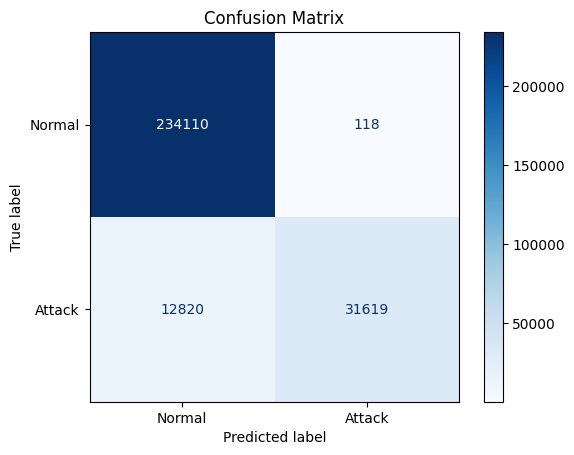

In [ ]:
plot_confusion_matrix(true_labels,predicted_labels)

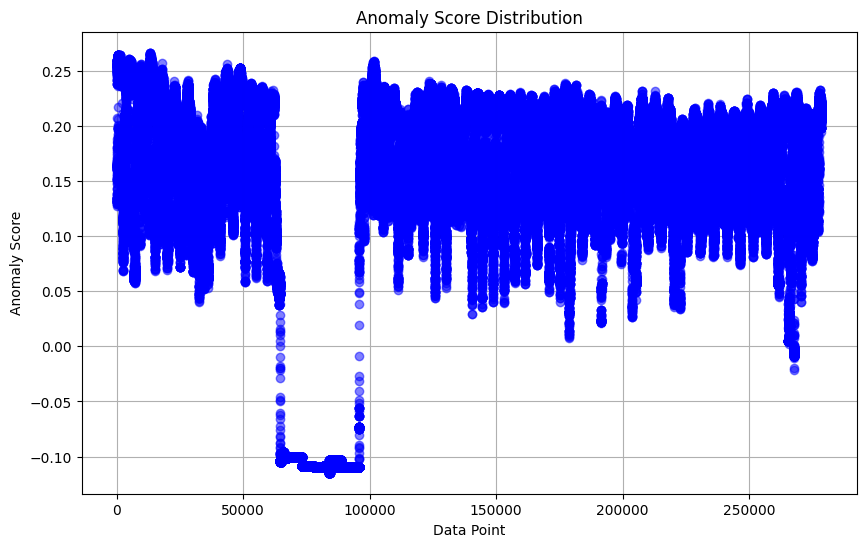

In [ ]:
# Anomaly Score Distribution
anomaly_scores = model.decision_function(X_test)
# Plotting Residuals
plt.figure(figsize=(10, 6))
plt.plot(anomaly_scores, marker='o', linestyle='None', color='b', alpha=0.5)
plt.xlabel('Data Point')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Score Distribution')
plt.grid(True)
plt.show()

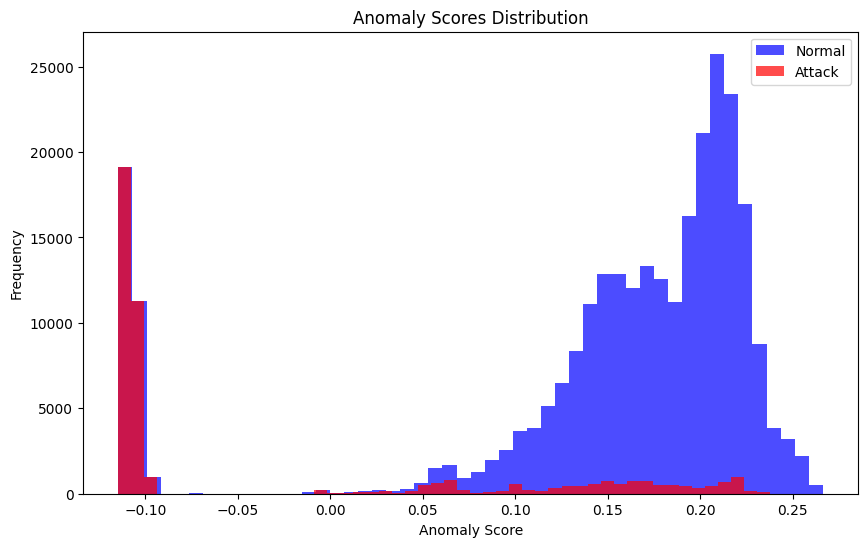

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores, bins=50, color='blue', alpha=0.7, label='Normal')
plt.hist(anomaly_scores[y_test == 1], bins=50, color='red', alpha=0.7, label='Attack')
plt.title('Anomaly Scores Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

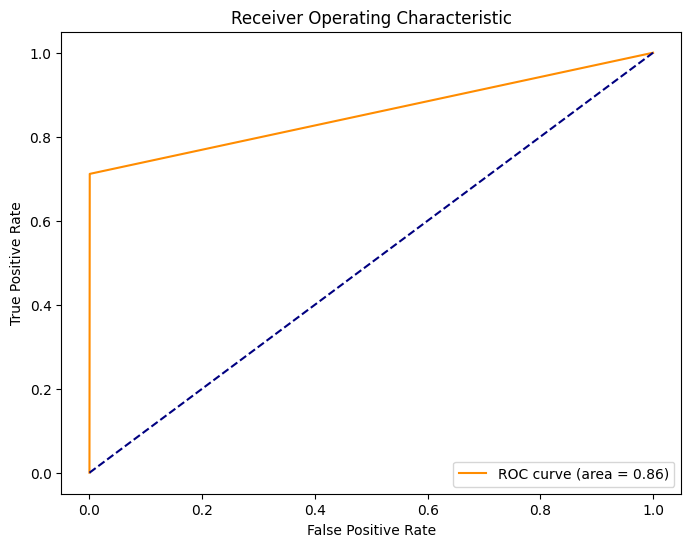

In [ ]:
plot_roc_curve(y_test, predicted_labels,'SWaT_IsolationF_DTW')

#**DTW Approach Implementation (StageWise)**

In [ ]:
# Define the features for each stage
stage_1_features = ['FIT101', 'LIT101']
stage_2_features = ['AIT202', 'AIT203', 'FIT201']
stage_3_features = ['DPIT301', 'FIT301', 'LIT301']
stage_4_features = ['AIT401','AIT402', 'FIT401', 'LIT401',]
stage_5_features = ['AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501','FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503']

# Combine all stage features into a list of lists
stage_features = [stage_1_features, stage_2_features, stage_3_features, stage_4_features, stage_5_features]


In [ ]:
#Split the Dataset Based on Stages
stage_dfs = [X_df[features] for features in stage_features]

In [ ]:
stage_dfs

[          FIT101    LIT101
 0       0.894987  0.160292
 1       0.890230  0.159845
 2       0.883848  0.159533
 3       0.879786  0.158819
 4       0.878510  0.158372
 ...          ...       ...
 928893  0.927477  0.453646
 928894  0.923532  0.454628
 928895  0.917150  0.454941
 928896  0.913437  0.454985
 928897  0.906359  0.455432
 
 [928898 rows x 2 columns],
           AIT202    AIT203    FIT201
 0       0.732892  0.073596  0.874201
 1       0.732892  0.073596  0.873249
 2       0.732892  0.073596  0.872796
 3       0.732892  0.073596  0.872524
 4       0.732892  0.073596  0.872524
 ...          ...       ...       ...
 928893  0.883013  0.058786  0.870030
 928894  0.883013  0.058786  0.870030
 928895  0.883013  0.058786  0.870257
 928896  0.883013  0.058786  0.870257
 928897  0.883013  0.058786  0.869577
 
 [928898 rows x 3 columns],
          DPIT301    FIT301    LIT301
 0       0.462186  0.940694  0.182199
 1       0.462186  0.940371  0.182199
 2       0.463182  0.939886  0.182

In [ ]:
#Apply DTW
window_size = 10

# Initialize an empty list to hold the DTW DataFrames for each stage
dtw_results = []

for stage_df, features in zip(stage_dfs, stage_features):
    dtw_distances_df = calculate_fastdtw_pairs(stage_df, features, window_size)
    dtw_results.append(dtw_distances_df)

In [ ]:
# Concatenate all DTW results into a single DataFrame
stage_wise_dtw_df = pd.concat(dtw_results, axis=1)

In [ ]:
stage_wise_dtw_df

FastDTW_FIT101_LIT101  FastDTW_AIT202_AIT203  FastDTW_AIT202_FIT201  \
9                    7.388695               6.592953               1.401127   
10                   7.446606               6.592953               1.400991   
11                   7.515558               6.592953               1.402260   
12                   7.592186               6.592953               1.404663   
13                   7.669644               6.592953               1.407338   
...                       ...                    ...                    ...   
928893               4.996352               8.253337               0.134589   
928894               4.960853               8.251778               0.133801   
928895               4.910938               8.250218               0.132787   
928896               4.854695               8.248659               0.132180   
928897               4.791963               8.247100               0.132253   

        FastDTW_AIT203_FIT201  FastDTW_DPIT301_FIT301  FastDTW_DPIT301_LIT301  \
9                    7.994080                4.774475                2.809189   
10                   7.993945                4.773615                2.810415   
11                   7.995214                4.773078                2.811828   
12                   7.997616                4.774022                2.812058   
13                   8.000291                4.775559                2.812063   
...                       ...                     ...                     ...   
928893               8.118747                4.709762                3.359489   
928894               8.117976                4.707900                3.355829   
928895               8.117432                4.708178                3.353213   
928896               8.116479                4.711072                3.353383   
928897               8.114846                4.715071                3.354747   

        FastDTW_FIT301_LIT301  FastDTW_AIT401_AIT402  FastDTW_AIT401_FIT401  \
9                    7.583665               1.566152               0.000000   
10                   7.584030               1.566152               0.000000   
11                   7.584907               1.566152               0.000000   
12                   7.586081               1.566152               0.000000   
13                   7.587623               1.566152               0.000000   
...                       ...                    ...                    ...   
928893               1.350273               9.751494               0.233857   
928894               1.352071               9.750166               0.233125   
928895               1.354965               9.749635               0.232758   
928896               1.357689               9.749901               0.232831   
928897               1.360324               9.750167               0.233417   

        FastDTW_AIT401_LIT401  ...  FastDTW_FIT503_FIT504  \
9                    1.234396  ...               0.021794   
10                   1.234572  ...               0.021794   
11                   1.235452  ...               0.021794   
12                   1.237301  ...               0.021794   
13                   1.239370  ...               0.021794   
...                       ...  ...                    ...   
928893               0.549005  ...               0.077141   
928894               0.546055  ...               0.071281   
928895               0.543414  ...               0.065421   
928896               0.540553  ...               0.064007   
928897               0.537780  ...               0.063603   

        FastDTW_FIT503_PIT501  FastDTW_FIT503_PIT502  FastDTW_FIT503_PIT503  \
9                    0.022684               0.021794               0.037416   
10                   0.022684               0.021794               0.037416   
11                   0.022684               0.021794               0.037416   
12                   0.022684               0.021794               0.037416   
13       

In [ ]:
#Save the stage_wise_dtw_df in csv format for future use
file_path = '/content/drive/My Drive/stage_wise_dtw_distances.csv'
stage_wise_dtw_df.to_csv(file_path)

In [ ]:
#Upload the stage_wise_dtw_df
file_path = '/content/drive/My Drive/stage_wise_dtw_distances.csv'

stage_wise_dtw_df = pd.read_csv(file_path)
window_size = 10

In [ ]:
y_df_aligned = y_df[(window_size - 1):]

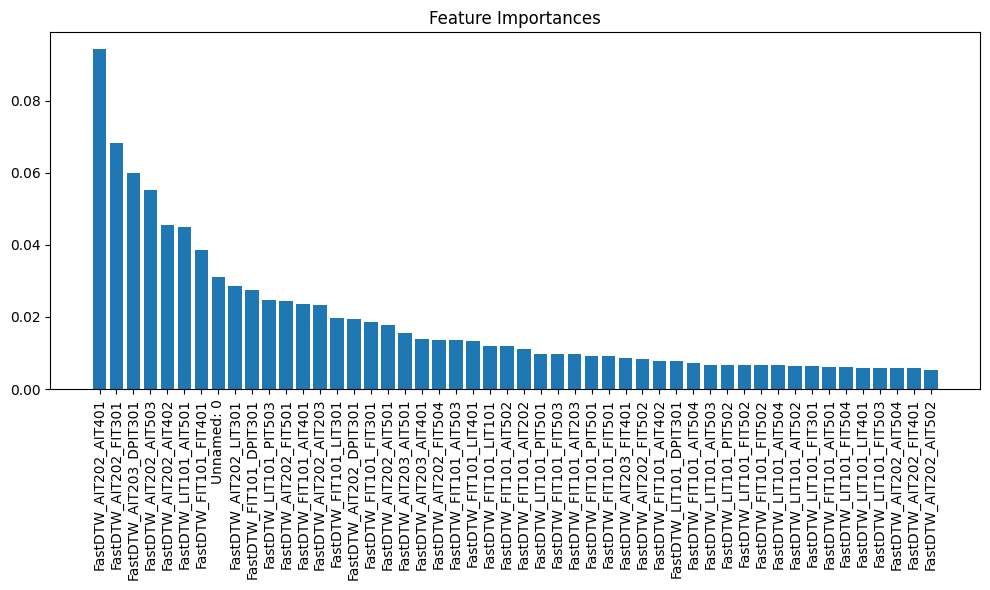

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(stage_wise_dtw_df, y_df_aligned)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# top 50 feature
top_n_indices = indices[:50]
reduced_dtw_stagewise = stage_wise_dtw_df.iloc[:, top_n_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(len(top_n_indices)), importances[top_n_indices], align='center')
plt.xticks(range(len(top_n_indices)), dtw_distances_df.columns[top_n_indices], rotation=90)
plt.tight_layout()
plt.show()

file_path = '/content/drive/My Drive/reduced_dtw_stagewise_distances.csv'
reduced_dtw_stagewise.to_csv(file_path, index=False)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    stage_wise_dtw_df, y_df_aligned, test_size=0.3, random_state=42, shuffle=False
)

## Autoencoder + StageWise DTW

In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train_normal = X_train[y_train == 0]
n_features= X_train_normal.shape[1]

In [ ]:
#Model with best param
model=create_model_autoencoder(n_features,n_units=256, activation='relu')
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Training the model
history=model.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
2004/2004 [==============================] - 11s 5ms/step - loss: 0.0072 - accuracy: 0.4119 - val_loss: 0.0024 - val_accuracy: 0.4675
Epoch 2/50
2004/2004 [==============================] - 11s 5ms/step - loss: 0.0012 - accuracy: 0.6024 - val_loss: 0.0017 - val_accuracy: 0.5643
Epoch 3/50
2004/2004 [==============================] - 11s 5ms/step - loss: 8.5814e-04 - accuracy: 0.6497 - val_loss: 0.0017 - val_accuracy: 0.5704
Epoch 4/50
2004/2004 [==============================] - 11s 5ms/step - loss: 6.7332e-04 - accuracy: 0.6797 - val_loss: 0.0018 - val_accuracy: 0.5186
Epoch 5/50
2004/2004 [==============================] - 11s 5ms/step - loss: 5.7665e-04 - accuracy: 0.7062 - val_loss: 0.0017 - val_accuracy: 0.5509
Epoch 6/50
2004/2004 [==============================] - 11s 5ms/step - loss: 5.2178e-04 - accuracy: 0.7256 - val_loss: 0.0016 - val_accuracy: 0.5210
Epoch 7/50
2004/2004 [==============================] - 11s 6ms/step - loss: 4.7705e-04 - accuracy: 0.7388 - val_l

In [ ]:
X_test_predictions = model.predict(X_test)

8709/8709 [==============================] - 16s 2ms/step


In [ ]:
mae = np.mean(np.abs(X_test_predictions - X_test), axis=1)
#Find the best threshold
thresholds = np.linspace(min(mae), max(mae), num=100)
precision_list, recall_list, f1_list = [], [], []

best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    predicted_anomalies = (mae > threshold).astype(int)
    precision = precision_score(y_test, predicted_anomalies)
    recall = recall_score(y_test, predicted_anomalies)
    f1 = f1_score(y_test, predicted_anomalies)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best F1 Score: {best_f1}")
print(f"Threshold for Best F1 Score: {best_threshold}")

Best F1 Score: 0.838082109835234
Threshold for Best F1 Score: 0.17428927028128327


In [ ]:
y_pred = (mae > best_threshold).astype(int)
evaluate_model_performance(y_test, y_pred)

Accuracy: 0.9552
Confusion Matrix:
[[233916    312]
 [ 12167  32272]]
Precision: 0.9904
Recall: 0.7262
F1-score: 0.8380
AUC: 0.8624

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    234228
           1       0.99      0.73      0.84     44439

    accuracy                           0.96    278667
   macro avg       0.97      0.86      0.91    278667
weighted avg       0.96      0.96      0.95    278667



##LSTM + StageWise DTW

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#reshape the data
train_data_dtw_2 = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
df_test_dtw_2 = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
def create_model_lstm(units=50, learning_rate=0.001, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(train_data_dtw_2.shape[1], train_data_dtw_2.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# # Define LSTM model
# def create_model_lstm_dtw(units=50):
#     model = Sequential()
#     model.add(LSTM(units=units, input_shape=(train_data_dtw_2.shape[1], train_data_dtw_2.shape[2])))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model


In [ ]:
print('Start training the model ==>')

lstm_model= create_model_lstm(units=50)
lstm_model.fit(train_data_dtw_2, y_train, epochs=10, batch_size=32,
    verbose=1,
    validation_split=0.2)

Start training the model ==>
Epoch 1/10
16256/16256 [==============================] - 158s 9ms/step - loss: 0.0220 - accuracy: 0.9933 - val_loss: 0.2160 - val_accuracy: 0.9621
Epoch 2/10
16256/16256 [==============================] - 141s 9ms/step - loss: 0.0170 - accuracy: 0.9942 - val_loss: 0.2115 - val_accuracy: 0.9548
Epoch 3/10
16256/16256 [==============================] - 122s 7ms/step - loss: 0.0155 - accuracy: 0.9947 - val_loss: 0.2135 - val_accuracy: 0.9585
Epoch 4/10
16256/16256 [==============================] - 122s 8ms/step - loss: 0.0145 - accuracy: 0.9951 - val_loss: 0.2195 - val_accuracy: 0.9629
Epoch 5/10
16256/16256 [==============================] - 123s 8ms/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.2209 - val_accuracy: 0.9595
Epoch 6/10
16256/16256 [==============================] - 126s 8ms/step - loss: 0.0116 - accuracy: 0.9960 - val_loss: 0.2619 - val_accuracy: 0.9618
Epoch 7/10
16256/16256 [==============================] - 118s 7ms/step - loss: 0.0

In [ ]:
y_pred_prob = lstm_model.predict(df_test_dtw_2)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

f1_scores = 2 * precision * recall / (precision + recall)

optimal_idx = np.argmax(f1_scores[np.isfinite(f1_scores)])
optimal_threshold = thresholds[optimal_idx]

print("The optimal threshold is :",optimal_threshold)

8709/8709 [==============================] - 27s 3ms/step
The optimal threshold is : 3.3965335e-07


In [ ]:
y_pred = (y_pred_prob > optimal_threshold).astype(int)

evaluate_model_performance(y_test, y_pred)

Accuracy: 0.8845
Confusion Matrix:
[[213001  21227]
 [ 10969  33470]]
Precision: 0.6119
Recall: 0.7532
F1-score: 0.6752
AUC: 0.8313

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93    234228
           1       0.61      0.75      0.68     44439

    accuracy                           0.88    278667
   macro avg       0.78      0.83      0.80    278667
weighted avg       0.90      0.88      0.89    278667



##Isolation Forest + StageWise DTW

In [ ]:
model = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(.01),
                             max_features=1.0, bootstrap=True, n_jobs=-1, random_state=42, verbose=0)

In [ ]:
model.fit(X_train)
predictions = model.predict(X_test)

binary_predictions = [1 if pred == -1 else 0 for pred in predictions]

In [ ]:
evaluate_model_performance(y_test, binary_predictions)

Accuracy: 0.9548
Confusion Matrix:
[[234023    205]
 [ 12394  32045]]
Precision: 0.9936
Recall: 0.7211
F1-score: 0.8357
AUC: 0.8601

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    234228
           1       0.99      0.72      0.84     44439

    accuracy                           0.95    278667
   macro avg       0.97      0.86      0.90    278667
weighted avg       0.96      0.95      0.95    278667



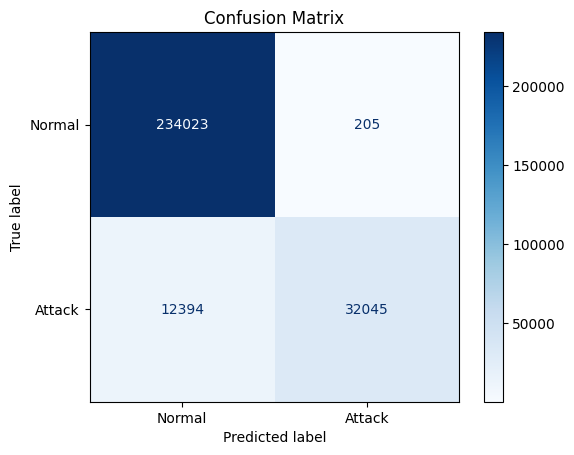

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, binary_predictions)


In [ ]:
# Anomaly Score Distribution
anomaly_scores = model.decision_function(X_test)

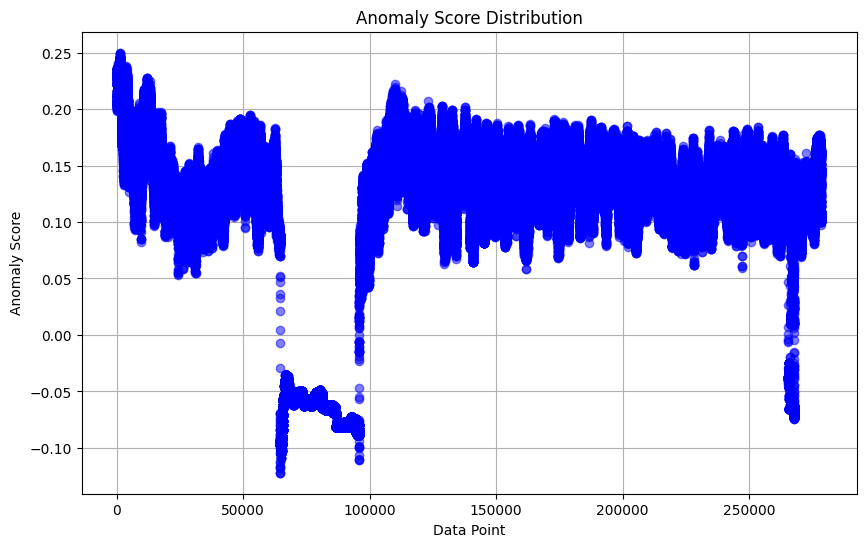

In [ ]:
# Plotting Residuals
plt.figure(figsize=(10, 6))
plt.plot(anomaly_scores, marker='o', linestyle='None', color='b', alpha=0.5)
plt.xlabel('Data Point')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Score Distribution')
plt.grid(True)
plt.show()

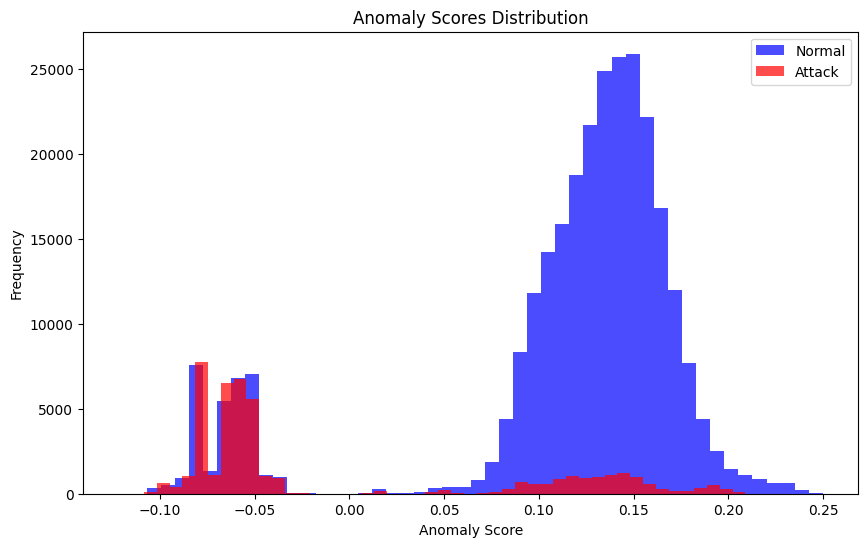

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores, bins=50, color='blue', alpha=0.7, label='Normal')
plt.hist(anomaly_scores[y_test == 1], bins=50, color='red', alpha=0.7, label='Attack')
plt.title('Anomaly Scores Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

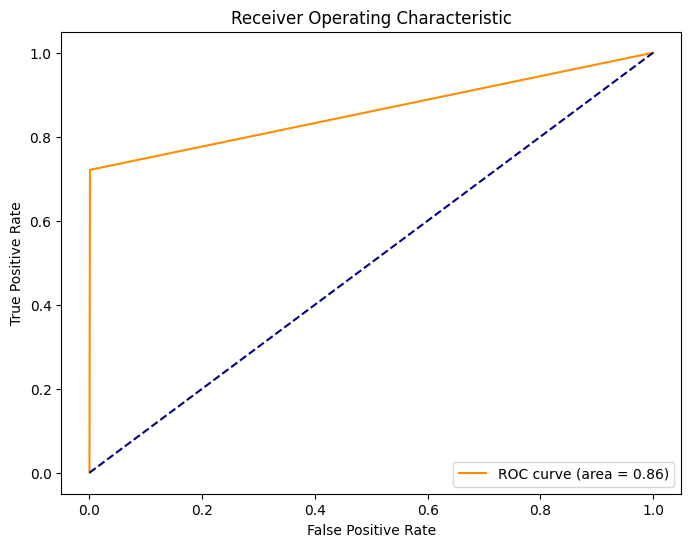

In [ ]:
plot_roc_curve(y_test, binary_predictions,'SWaT_DTW-S_IsolationF')